In [1]:
from tqdm import tqdm
%run model_evaluation
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import defaultdict

import matplotlib.pyplot as plt
import proplot as pplt

# model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)
# env = gym.make('NavEnv-v0', **kwargs)

save = 'plots/representation_learning/'

In [2]:
print_trained_models(ignore_non_pt=True)

ppo
├── nav_auxiliary_tasks
│   ├── EXP nav_c2_auxeuclid0: 5
│   ├── EXP nav_c2_auxeuclid1: 5
│   ├── EXP nav_c2_auxeuclid2: 5
│   ├── EXP nav_c2_auxwall1: 5
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 10
│   ├── EXP nav_c4_auxeuclid1: 10
│   ├── EXP nav_c4_auxeuclid2: 10
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_auxiliary_tasks2
│   ├── EXP nav_c4_auxeuclid0: 5
├── nav_invisible_shared
│   ├── EXP nav_c4_shared0.dist: 5
│   ├── EXP nav_c4_shared0: 5
│   ├── EXP nav_c4_shared1.dist: 5
│   ├── EXP nav_c4_shared1: 5
│   ├── EXP nav_c4_shared2.dist: 5
│   ├── EXP nav_c4_shared2: 5
├── nav_invisible_wallcolors
│   ├── EXP nav_c1_dist: 3
│   ├── EXP nav_c2.5_dist: 5
│   ├── EXP nav_c2.5_none: 5
│   ├── EXP nav_c2_dist: 5
│   ├── EXP nav_c2_none: 5
│   ├── EXP nav_c4_dist: 5
│   ├── EXP nav_c4_none: 5
├── nav_poster
│   ├── EXP nav_pdistal_auxeuclid0: 5
│   ├── EXP nav_pdistal_auxeuclid1: 5
│   ├── EXP nav_pdistal_auxeuclid2: 5
│   ├── EXP nav_pd

In [2]:
# Note - these parameters are important for classifier training

WINDOW_SIZE = (300, 300)

num_grid_slices = 5 # how many grid squares to slice maze into
num_grid_points = num_grid_slices**2

xs_grid = np.linspace(0, WINDOW_SIZE[0], num_grid_slices, endpoint=False)
ys_grid = np.linspace(0, WINDOW_SIZE[1], num_grid_slices, endpoint=False)

softmax = nn.Softmax(dim=1)


def activation_testing(model, env, x, y, angle):
    """
    Pass a model and corresponding environment, x, y and angle, then 
    get the observation and perform a prediction with model to get activations
    
    returns:
        outputs object from model.base.forward
    
    outputs['activations'] is the activation dict
    note that outputs['activations']['shared_activations'] is the same as the 
        rnn hidden state output
    """
    vis_walls = env.vis_walls
    vis_wall_refs = env.vis_wall_refs
    
    env.character.pos = np.array([x, y])
    env.character.angle = angle
    env.character.update_rays(vis_walls, vis_wall_refs)
    
    obs = torch.tensor(env.get_observation(), dtype=torch.float32).view(1, -1)
    rnn_hxs = torch.zeros(1, model.recurrent_hidden_state_size, dtype=torch.float32)
    masks = torch.zeros(1, 1, dtype=torch.float32)
    
    outputs = model.base.forward(obs, rnn_hxs, masks, with_activations=True)
    outputs['obs'] = obs
    return outputs



def stack_activations(activation_dict, also_ret_list=False):
    '''
    Activations passed back from a FlexBase forward() call can be appended, e.g.
    all_activations = []
    for ...:
        all_activations.append(actor_critic.act(..., with_activations=True)['activations'])
        
    This will result in a list of dictionaries
    
    This function converts all_activations constructed in this way into a dictionary,
    where each value of the dictionary is a tensor of shape
    [layer_num, seq_index, activation_size]
    
    Args:
        also_ret_list: If True, will also return activations in a list one-by-one
            rather than dict form. Good for matching up with labels and classifier ordering
            from train classifiers function
    '''
    stacked_activations = defaultdict(list)
    list_activations = []
    keys = activation_dict[0].keys()
    
    for i in range(len(activation_dict)):
        for key in keys:
            num_layers = len(activation_dict[i][key])
            
            if num_layers > 0:
                # activation: 1 x num_layers x activation_size
                activation = torch.vstack(activation_dict[i][key]).reshape(1, num_layers, -1)
                # stacked_activations: list (1 x num_layers x activation_size)
                stacked_activations[key].append(activation)
    
    for key in stacked_activations:
        activations = torch.vstack(stacked_activations[key]) # seq_len x num_layers x activation_size
        activations = activations.transpose(0, 1) # num_layers x seq_len x activation_size
        stacked_activations[key] = activations
        
        #Generate activations in list form
        if also_ret_list:
            for i in range(activations.shape[0]):
                list_activations.append(activations[i])
    
    if also_ret_list:
        return stacked_activations, list_activations
    else:
        return stacked_activations


def find_grid_index(point=None, x=None, y=None):
    if point is not None:
        x = point[0]
        y = point[1]
    elif x is not None and y is not None:
        pass
    else:
        raise Exception('No valid argument combination given')
        
    x_grid_idx = np.max(np.argwhere(x >= xs_grid))
    y_grid_idx = np.max(np.argwhere(y >= ys_grid))
    total_grid_idx = x_grid_idx * num_grid_slices + y_grid_idx
    return total_grid_idx



def train_classifier(x, labels, valid_x=None, valid_labels=None, num_labels=None,
                     lr=0.1, epochs=1000, prog=False):
    '''
    Train an arbitrary classifier
        x (tensor): train X data
        labels (tensor): train labels
        valid_x (tensor, optional): train valid X data
        valid_labels (tensor, optional): train valid labels
        num_labels (int, optional): number of output labels
            for model to output. If not provided, default is
            given by the largest label value in labels
    '''
    if num_labels is None:
        num_labels = labels.max().item() + 1
    linear = nn.Linear(x.shape[1], num_labels)
    optimizer = optim.Adam(linear.parameters(), lr=lr)
    softmax = nn.Softmax(dim=1)
    # optimizer = optim.SGD(linear.parameters(), lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    valid_accuracies = []
    if prog:
        it = tqdm(range(epochs))
    else:
        it = range(epochs)
        
    for i in it:
        y = linear(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy_score(softmax(y.detach()).argmax(axis=1), labels))

        if valid_x is not None and valid_labels is not None:
            pred_valid = softmax(linear(valid_x)).argmax(axis=1)
            valid_accuracies.append(accuracy_score(pred_valid, valid_labels))
            
    return linear, losses, accuracies, valid_accuracies


def draw_character(pos, angle, size=10, ax=None):
    angle1 = angle - 0.3
    angle2 = angle + 0.3
    point1 = [pos[0], pos[1]]
    point2 = [pos[0] - np.cos(angle1)*size, pos[1] - np.sin(angle1)*size]
    point3 = [pos[0] - np.cos(angle2)*size, pos[1] - np.sin(angle2)*size]

    draw_color = np.array([0.9, 0.9, 0])

    poly = plt.Polygon([point1, point2, point3], fc=draw_color)
    if ax is None:
        plt.gca().add_patch(poly)
    else:
        ax.add_patch(poly)

        
def get_activations(model, obs, masks, pos, device=torch.device('cpu')):
    eval_recurrent_hidden_states = torch.zeros(
        num_processes, model.recurrent_hidden_state_size, device=device)

    with torch.no_grad():
        outputs = model.base(obs, eval_recurrent_hidden_states, 
                               masks, deterministic=True, with_activations=True)
    
    #For some reason, the first ~100ish activations are misaligned with the original
    #activations if the agent is run with the episodes live, so remove some early misalignment
    skip = 0
    
    activations = outputs['activations']
    stacked = {}
    for key in activations:
        substacked = []
        for i in range(len(activations[key])):
            activ = activations[key][i][skip:, :]
            shape = activ.shape
            substacked.append(activ.reshape(1, shape[0], shape[1]))
        stacked[key] = torch.vstack(substacked)
    pos = pos[skip:]
    # angle = angle[skip:]

    return stacked, pos
    

def train_position_classifier(model, obs_rms=None, kwargs=None, model_num=None, 
                              train_episodes=30, valid_episodes=5, epochs=100, 
                              seed=0, random_actions=True):
    '''
    Complete automated training of a position decoder
    model (str or Policy): the model to be trained, can either be a
        path to trained model from ../trained_models/ppo/ or a policy directly
    
    model (str):
        model_num (int): Need to also pass the trial number to load
    model (Policy):
        obs_rms, kwargs: These are usually loaded from load_model_and_env
            so when a Policy is passed, need to pass these as well
    '''
    
    if model_num is not None and type(model) == str:
        model, obs_rms, kwargs = load_model_and_env(model, model_num)
    elif obs_rms is not None and kwargs is not None \
        and type(model) == Policy:
        pass
    else:
        raise ValueError('Must pass either model (str) + model_num or model (Policy) + obs_rms + kwargs')
    
    # Generate activations and positions for training and validation
    train_results = perform_ep_collection(model, obs_rms, kwargs,
                                     seed=seed, num_episodes=train_episodes, random_actions=random_actions)
    stacked, grid_indexes = train_results['stacked'], train_results['grid_indexes']

    valid_results = perform_ep_collection(model, obs_rms, kwargs,
                                     seed=seed, num_episodes=valid_episodes, random_actions=random_actions)
    valid_stacked, valid_grid_indexes = train_results['stacked'], train_results['grid_indexes']
    
    # Train position decoders on activations
    classifiers = {}

    all_losses = []
    all_accuracies = []
    labels = []
    valid_accuracies = []
    
    valid_preds = []

    for key in stacked:
        # print(key)
        num_layers = stacked[key].shape[0]
        for i in range(num_layers):            
            x = stacked[key][i]
            valid_x = valid_stacked[key][i]
            
            linear, losses, accuracies, _ = train_classifier(x, grid_indexes, epochs=epochs)
            classifiers[f'{key}_{i}'] = linear
            
            labels.append(f'{key}_{i}')
            all_losses.append(losses)
            all_accuracies.append(accuracies)
    
            pred_valid = linear(valid_x).argmax(axis=1)
        
            valid_preds.append(pred_valid)
            
            accuracy_score(pred_valid, valid_grid_indexes)
            valid_accuracies.append(accuracy_score(pred_valid, valid_grid_indexes))
    return {
        'labels': labels,
        'losses': all_losses,
        'training_acc': all_accuracies,
        'final_valid_acc': valid_accuracies,
        'classifiers': classifiers,
        
        'valid_preds': valid_preds,
        'valid_grid_indexes': valid_grid_indexes
    }
    
    
def quick_vec_env(obs_rms, env_kwargs={}, env_name='NavEnv-v0', seed=0,
                 num_processes=1, eval_log_dir='/tmp/gym/_eval',
                 device=torch.device('cpu'), capture_video=False):
    eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
                          None, eval_log_dir, device, True, 
                          capture_video=capture_video, 
                          env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms
        
    return eval_envs

    
def perform_ep_collection(model, obs_rms=None, kwargs=None, model_num=None, 
                          num_episodes=1, seed=0, random_actions=False,
                         data_callback=nav_data_callback):
    '''
    Collect activations, positions, etc. for a number of episodes
    Used by train_position_classifier to collect activation and pos data
    Can also be used to generate single episodes of data to evaluate classifiers etc.
    
    Same model (str / Policy) parameters as train_position_classifier
    '''
    if model_num is not None and type(model) == str:
        model, obs_rms, kwargs = load_model_and_env(model, model_num)
    elif obs_rms is not None and kwargs is not None \
        and type(model) == Policy:
        pass
    else:
        raise ValueError('Must pass either model (str) + model_num or model (Policy) + obs_rms + kwargs')

    
    # Generate random episodes to train on
    if seed is not None:
        np.random.seed(seed)
    action_randomizer = lambda step: np.random.choice([0, 1, 2])
    
    if random_actions:
        results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, seed=seed,
                                        data_callback=nav_data_callback, num_episodes=num_episodes, with_activations=True)
    else:
        results = forced_action_evaluate(model, obs_rms, env_kwargs=kwargs, seed=seed,
                                        data_callback=nav_data_callback, num_episodes=num_episodes, with_activations=True)

    pos = np.vstack(results['data']['pos'])
    angle = torch.tensor(np.vstack(results['data']['angle']))
    stacked, listed_activ = stack_activations(results['activations'], also_ret_list=True)
    grid_indexes = torch.tensor([find_grid_index(p) for p in pos])
    
    results['pos'] = pos
    results['angle'] = angle
    results['stacked'], results['listed_activ'] = stacked, listed_activ
    results['grid_indexes'] = grid_indexes
    
    return results
    
    


# Train single MLP layer on non-episodic activations

Either take a grid of points and rotate angles about the points, then collect observations, or take randomly sampled points and angles. Then train a single layer MLP to detect where the agent is. This may be too challenging, so we may need to attempt to train a classifier to output where on a grid the agent is instead.

## Generate points (run before sections 1.2+)

Here we generate a set of training points for later sections to train with. Can either generate them by grid points or by generating a random set of points and angles

In [1]:
'''
Generate activations from the network - for a grid of points, rotate
around to get visual inputs to the system and get activations from trained model
'''

WINDOW_SIZE = (300, 300)
#Random points
num_points = 5000
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)

# outputs = activation_testing(model, env, 5, 5, 0)
all_activations = []            
all_obs = []

points = []
angles = []
pbar = tqdm()
with torch.no_grad():
    for i in range(num_points):
        x = rand_points[i, 0]
        y = rand_points[i, 1]
        angle = rand_angles[i]

        outputs = activation_testing(model, env, x, y, angle)
        all_activations.append(outputs['activations'])
        all_obs.append(outputs['obs'])

        pbar.update(1)
pbar.close()

stacked_activations = stack_activations(all_activations)
all_obs = torch.vstack(all_obs)



# Turn points into trainable data
points = np.array(rand_points)
angles = np.array(rand_angles)

scaled_points = np.zeros(points.shape)
scaled_points[:, 0] = points[:, 0]/np.max(points[:, 0])
scaled_points[:, 1] = points[:, 1]/np.max(points[:, 1])

scaled_angles = angles / np.max(angles)

scaled_points = torch.tensor(scaled_points, dtype=torch.float32)
scaled_angles = torch.tensor(scaled_angles, dtype=torch.float32)



NameError: name 'np' is not defined

In [2]:
'''
Generate activations from the network - for a grid of points, rotate
around to get visual inputs to the system and get activations from trained model
'''

# Grid points
step_size = 10
xs = np.arange(0+step_size, WINDOW_SIZE[0], step_size)
ys = np.arange(0+step_size, WINDOW_SIZE[1], step_size)
thetas = np.linspace(0, 2*np.pi, 12, endpoint=False)

activations = activation_testing(model, env, 5, 5, 0)

activation_dict = {}

def append_activation_dict(activations, activation_dict):
    # Add keys to dict
    for key in activations:
        act = activations[key]
        if key not in activation_dict:
            activation_dict[key] = []
            if type(act) == list:
                for i in range(len(act)):
                    activation_dict[key].append([])
                
    # Append activation vectors to dict
    for key in activations:
        act = activations[key]
        if type(act) == list:
            for i in range(len(act)):
                activation_dict[key][i].append(act[i].squeeze())
        else:
            activation_dict[key].append(activations[key].squeeze())
            
    
points = []
angles = []
pbar = tqdm(total=len(xs)*len(ys)*len(angles))
activation_dict = {}
with torch.no_grad():
    for x in xs:
        for y in ys:
            for angle in thetas:
                points.append([x, y])
                angles.append(angle)

                activations = activation_testing(model, env, x, y, angle)
                append_activation_dict(activations, activation_dict)

                pbar.update(1)
pbar.close()

# Turn points into trainable data

points = np.array(points)
angles = np.array(angles)

scaled_points = np.zeros(points.shape)
scaled_points[:, 0] = points[:, 0]/np.max(points[:, 0])
scaled_points[:, 1] = points[:, 1]/np.max(points[:, 1])

scaled_angles = angles / np.max(angles)

scaled_points = torch.tensor(scaled_points, dtype=torch.float32)
scaled_angles = torch.tensor(scaled_angles, dtype=torch.float32)

NameError: name 'np' is not defined

## Train linear model for regression of position

This ends up being too difficult for both grid and randomly sampled points. Try instead grid method

In [72]:
'''
Train model on activations - try to find a single linear layer that
can map activation to position
'''

def train_linear_model(x, y, valid_x=None, valid_y=None, epochs=100):
    linear = nn.Linear(x.shape[1], y.shape[1])
    optimizer = optim.Adam(linear.parameters())
    mse_loss = nn.MSELoss()
    losses = []
    for i in range(100):
        y_pred = linear(x)
        optimizer.zero_grad()

        loss = mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if valid_x is not None and valid_y is not None:
        with torch.no_grad():
            pred = linear(valid_x) * 300
            mse = mse_loss(pred, valid_y)
            return linear, mse
    
    return linear

# Generate validation points
num_points = 100
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)
valid_activations = []
valid_obs = []
for i in range(num_points):
    x = rand_points[i, 0]
    y = rand_points[i, 1]
    angle = rand_angles[i]
    outputs = activation_testing(model, env, x, y, angle)
    valid_activations.append(outputs['activations'])
    valid_obs.append(outputs['obs'])

valid_activations = stack_activations(valid_activations)
valid_obs = torch.vstack(valid_obs)
valid_y = torch.tensor(rand_points, dtype=torch.float32)

results_dict = defaultdict(list)


for key in stacked_activations:
    num_layers = stacked_activations[key].shape[0]
    for i in range(num_layers):
        x = stacked_activations[key][i]
        linear, mse = train_linear_model(x, scaled_points, 
                            valid_x=valid_activations[key][i], valid_y=valid_y)
        results_dict[f'{key}_{i}'] = mse
    
    
# x = torch.vstack(activation_dict['actor_x'])
print(results_dict)

defaultdict(<class 'list'>, {'shared_activations_0': tensor(7086.9556), 'actor_activations_0': tensor(4925.1733), 'actor_activations_1': tensor(7587.1050), 'critic_activations_0': tensor(6282.2012), 'critic_activations_1': tensor(6219.3120)})


## Train classifier to output which grid of given granularity the agent might be in

In [261]:
grid_indexes = [find_grid_index(point) for point in points]
grid_indexes = torch.tensor(grid_indexes)


# Generate validation points
num_points = 100
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)
valid_activations = []
valid_obs = []
for i in range(num_points):
    x = rand_points[i, 0]
    y = rand_points[i, 1]
    angle = rand_angles[i]
    outputs = activation_testing(model, env, x, y, angle)
    valid_activations.append(outputs['activations'])
    valid_obs.append(outputs['obs'])

valid_activations = stack_activations(valid_activations)
valid_obs = torch.vstack(valid_obs)

valid_grid_indexes = [find_grid_index(point) for point in rand_points]
valid_grid_indexes = torch.tensor(valid_grid_indexes)



In [263]:
results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 2000


for key in stacked_activations:
    print(key)
    num_layers = stacked_activations[key].shape[0]
    for i in range(num_layers):
        x = stacked_activations[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                            valid_x=valid_activations[key][i], 
                            valid_labels=valid_grid_indexes, epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)

        

# Train a classifier from observation alone
print('obs')
x = all_obs
linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes,
                                                valid_obs, valid_grid_indexes, epochs=epochs)
labels.append('obs')
results_dict['obs'] = linear
all_losses.append(losses)
all_accuracies.append(accuracies)
all_valid_accuracies.append(valid_accuracies)

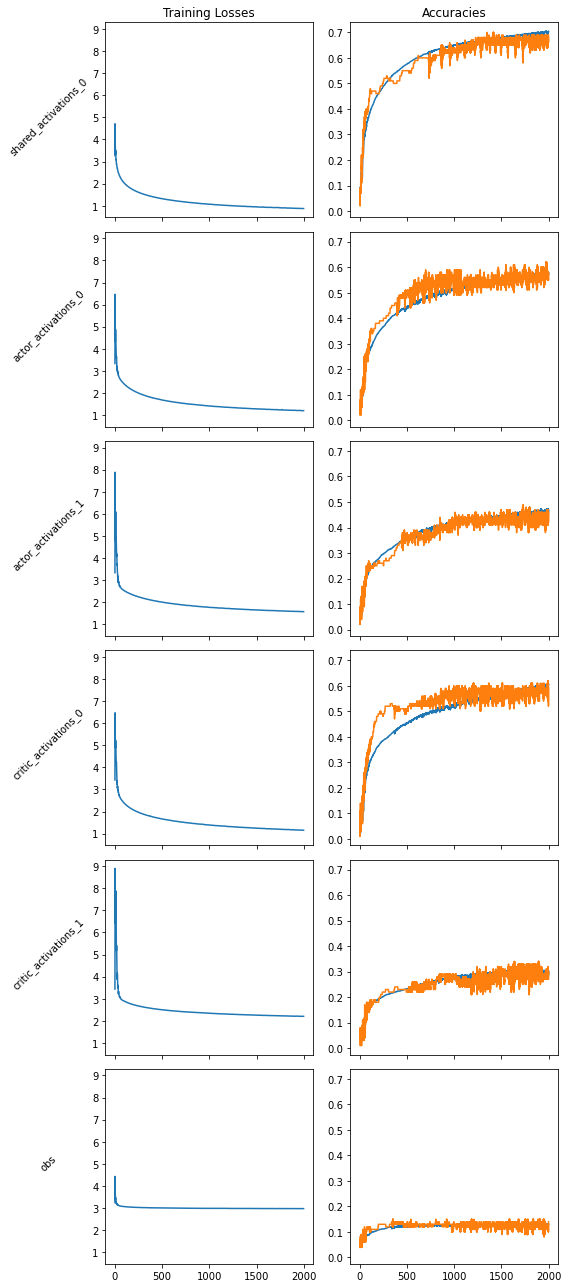

In [93]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
plt.savefig(save+'1_3_classifier_training_curves.jpg', bbox_inches='tight')

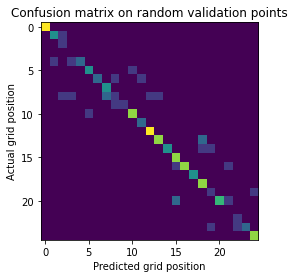

In [282]:
linear = results_dict['shared_activations_0']
y = linear(valid_activations['shared_activations'][0])
pred_labels = y.argmax(axis=1)

valid_grid_indexes

plt.imshow(confusion_matrix(pred_labels, valid_grid_indexes))
plt.title('Confusion matrix on random validation points')
plt.xlabel('Predicted grid position')
plt.ylabel('Actual grid position')
plt.savefig(save + '1_3_classifier_confusion_matrix', bbox_inches='tight')

# Train single MLP layer on episodic activations

## Running episodes starting at points on grid

Split grid into 9x9 (81 total starting points), facing away from center. Record positions and activations, train classifier to decode position from activations.

We note that using episodic activations has much more exploitable structure to perform decoding with, allowing for faster convergence of MLP and higher accuracies. It is likely that this follows the auxiliary task navigation paper, wherein the position of the agent can be decoded much more accurately as the episode progresses.

Next
* Need to create a validation methodology, since it is no longer accurate to just use random initial points for validation, actually need to follow a trajectory
* Would like to determine whether we can do this with a fixed trajectory i.e., actions that are not determined by the policy but either by random or determined by us. See if activations can still be decoded - this allows greater flexibility for testing

In [6]:
model, obs_rms, env = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 
                                            0, env_name='NavEnv-v0')

In [254]:
WINDOW_SIZE = (300, 300)
step_size = 30
xs = np.arange(0+step_size, WINDOW_SIZE[0], step_size)
ys = np.arange(0+step_size, WINDOW_SIZE[1], step_size)
# thetas = np.linspace(0, 2*np.pi, 12, endpoint=False)
points = []
angles = []
for x in xs:
    for y in ys:
        point = np.array([x, y])
        
        # # Face the center
        # angle = np.arctan2(150 - x, 150 - y)
        
        #Face away from center
        angle = np.arctan2(x - 150, y - 150)
        
        points.append(point)
        angles.append(angle)

all_results = []
for i in tqdm(range(len(points))):
    point = points[i]
    angle = angles[i]
    kwargs['fixed_reset'] = [point, angle]
    results = evalu(model, obs_rms, n=1, env_kwargs=kwargs, with_activations=True,
                    data_callback=nav_data_callback)
    all_results.append(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:05<00:00, 14.23it/s]


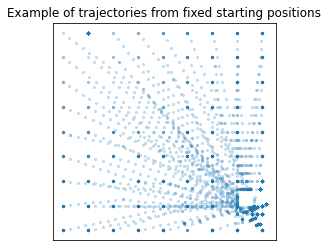

In [257]:
#stitch together positions and activations
pos = np.vstack([np.vstack(all_results[i]['data']['pos']) for i in range(len(all_results))])

all_activations = []
for i in range(len(all_results)):
    all_activations += all_results[i]['activations']
stacked = stack_activations(all_activations)

grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

plt.figure(figsize=(4,4))
plt.scatter(pos.T[0], pos.T[1], alpha=0.2, s=5)
plt.xticks([])
plt.yticks([])
plt.title('Example of trajectories from fixed starting positions')
plt.savefig(save + '2_1_grid_start_trajectories', bbox_inches='tight')

In [35]:
results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 1000


for key in stacked:
    print(key)
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                            valid_x=valid_activations[key][i], 
                            valid_grid_indexes=valid_grid_indexes, epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)


shared_activations
actor_activations
critic_activations


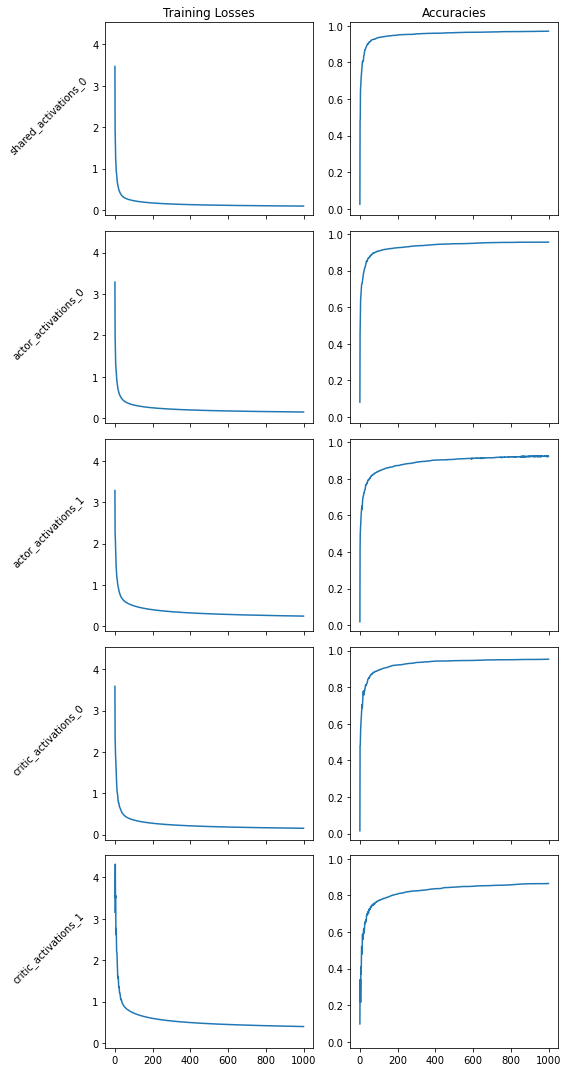

In [37]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    # ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
# plt.savefig('plots/representation_learning/1_3_classifier_training_curves.jpg', bbox_inches='tight')

## Testing forced action episodes

It appears we can very effectively perform the same grid classifier training on episodes that are run with random actions, so the actual actions taken don't seem to directly influence the activation trajectories (indirectly of course). This means that we can control an agent to move in certain trajectories and manipulate the sequence of observations seen to test specific representations learned

In [ ]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=50, with_activations=True)

pos = np.vstack(results['data']['pos'])
angle = torch.tensor(np.vstack(results['data']['angle']))
stacked = stack_activations(results['activations'])
grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

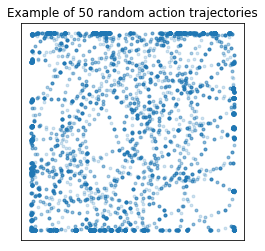

In [251]:
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
plt.scatter(pos.T[0], pos.T[1], alpha=0.2, s=8)
plt.title('Example of 50 random action trajectories')
plt.savefig(save + '2_2_forced_actions_random_trajectories', bbox_inches='tight')

In [85]:
# Train position decoder classifiers

results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 300


for key in stacked:
    print(key)
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                                                                             epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)

shared_activations
actor_activations
critic_activations


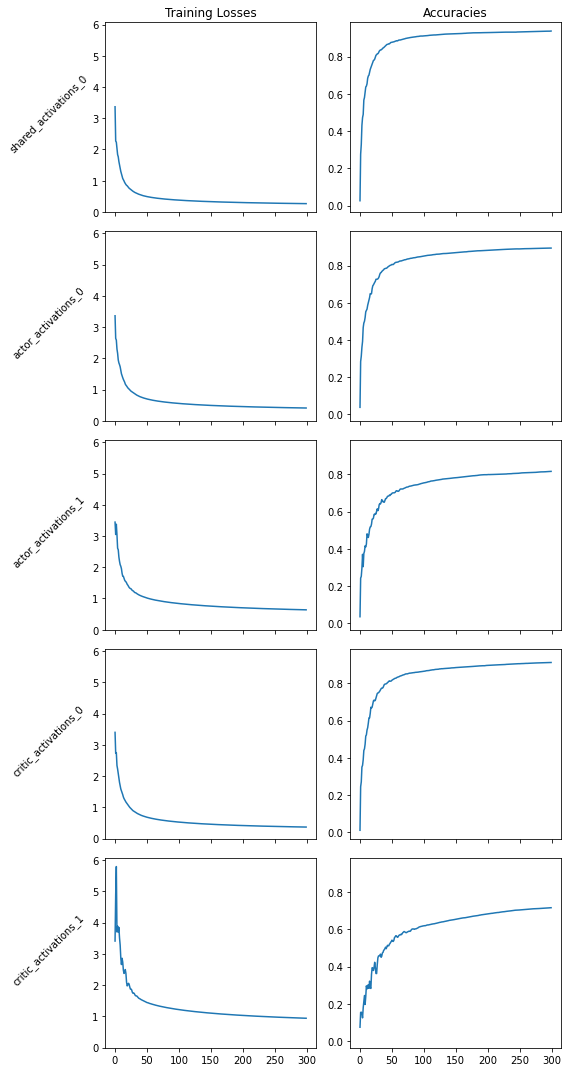

In [252]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    # ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
# plt.savefig('plots/representation_learning/1_3_classifier_training_curves.jpg', bbox_inches='tight')
plt.savefig(save + '2_2_pos_classifier_random_action', bbox_inches='tight')

### Testing to see how quickly in an episode agent position can be decoded accurately

In [139]:
action_randomizer = lambda step: np.random.choice([0, 1, 2])
one_ep = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


one_ep_pos = np.vstack(one_ep['data']['pos'])
one_ep_angle = np.vstack(one_ep['data']['angle'])
one_ep_stacked = stack_activations(one_ep['activations'])

#Use the trained classifier as grid-wise position decoder
with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    y = results_dict['shared_activations_0'](one_ep_stacked['shared_activations'][0])
    probs = softmax(y)

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


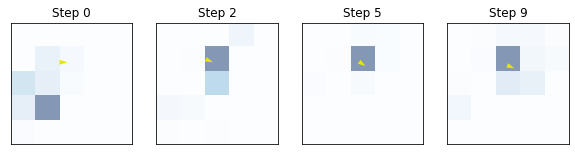

In [283]:
steps = [0, 2, 5, 9]
fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, step in enumerate(steps):
    ax[i].imshow(probs[step].reshape(5,5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    # plt.scatter(one_ep_pos.T[0, :step], one_ep_pos.T[1, :step], alpha=0.2)
    draw_character(one_ep_pos[step], one_ep_angle[step], 20, ax=ax[i])
    ax[i].set_title(f'Step {step}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.savefig(save + '2_2_1_live_episode_decoding', bbox_inches='tight')
    


### Observing data distribution of activations

In [95]:
import umap
reducer = umap.UMAP()

embedding = reducer.fit_transform(stacked['shared_activations'][0])

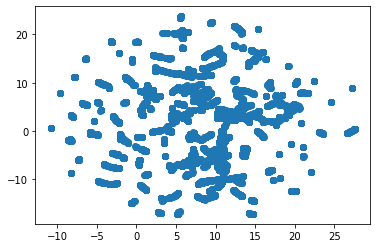

In [97]:
plt.scatter(embedding.T[0], embedding.T[1])

# Testing other representation classifiers

## Angle classifier

In [4]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=50, with_activations=True)

pos = np.vstack(results['data']['pos'])
angle = torch.tensor(np.vstack(results['data']['angle']))
stacked = stack_activations(results['activations'])
grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

In [7]:
angle_grid = np.linspace(-np.pi, np.pi, 12)

def categorize_angle(angle):
    angle_grid_idx = np.max(np.argwhere(angle >= angle_grid))
    return angle_grid_idx

angle_indexes = [categorize_angle(angle) for angle in results['data']['angle']]
angle_indexes = torch.tensor(angle_indexes)

all_losses = []
all_accuracies = []
labels = []

for key in stacked:
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, acc, valid_acc = train_classifier(x, angle_indexes)
        all_losses.append(losses)
        all_accuracies.append(acc)
        labels.append(f'{key}_{i}')



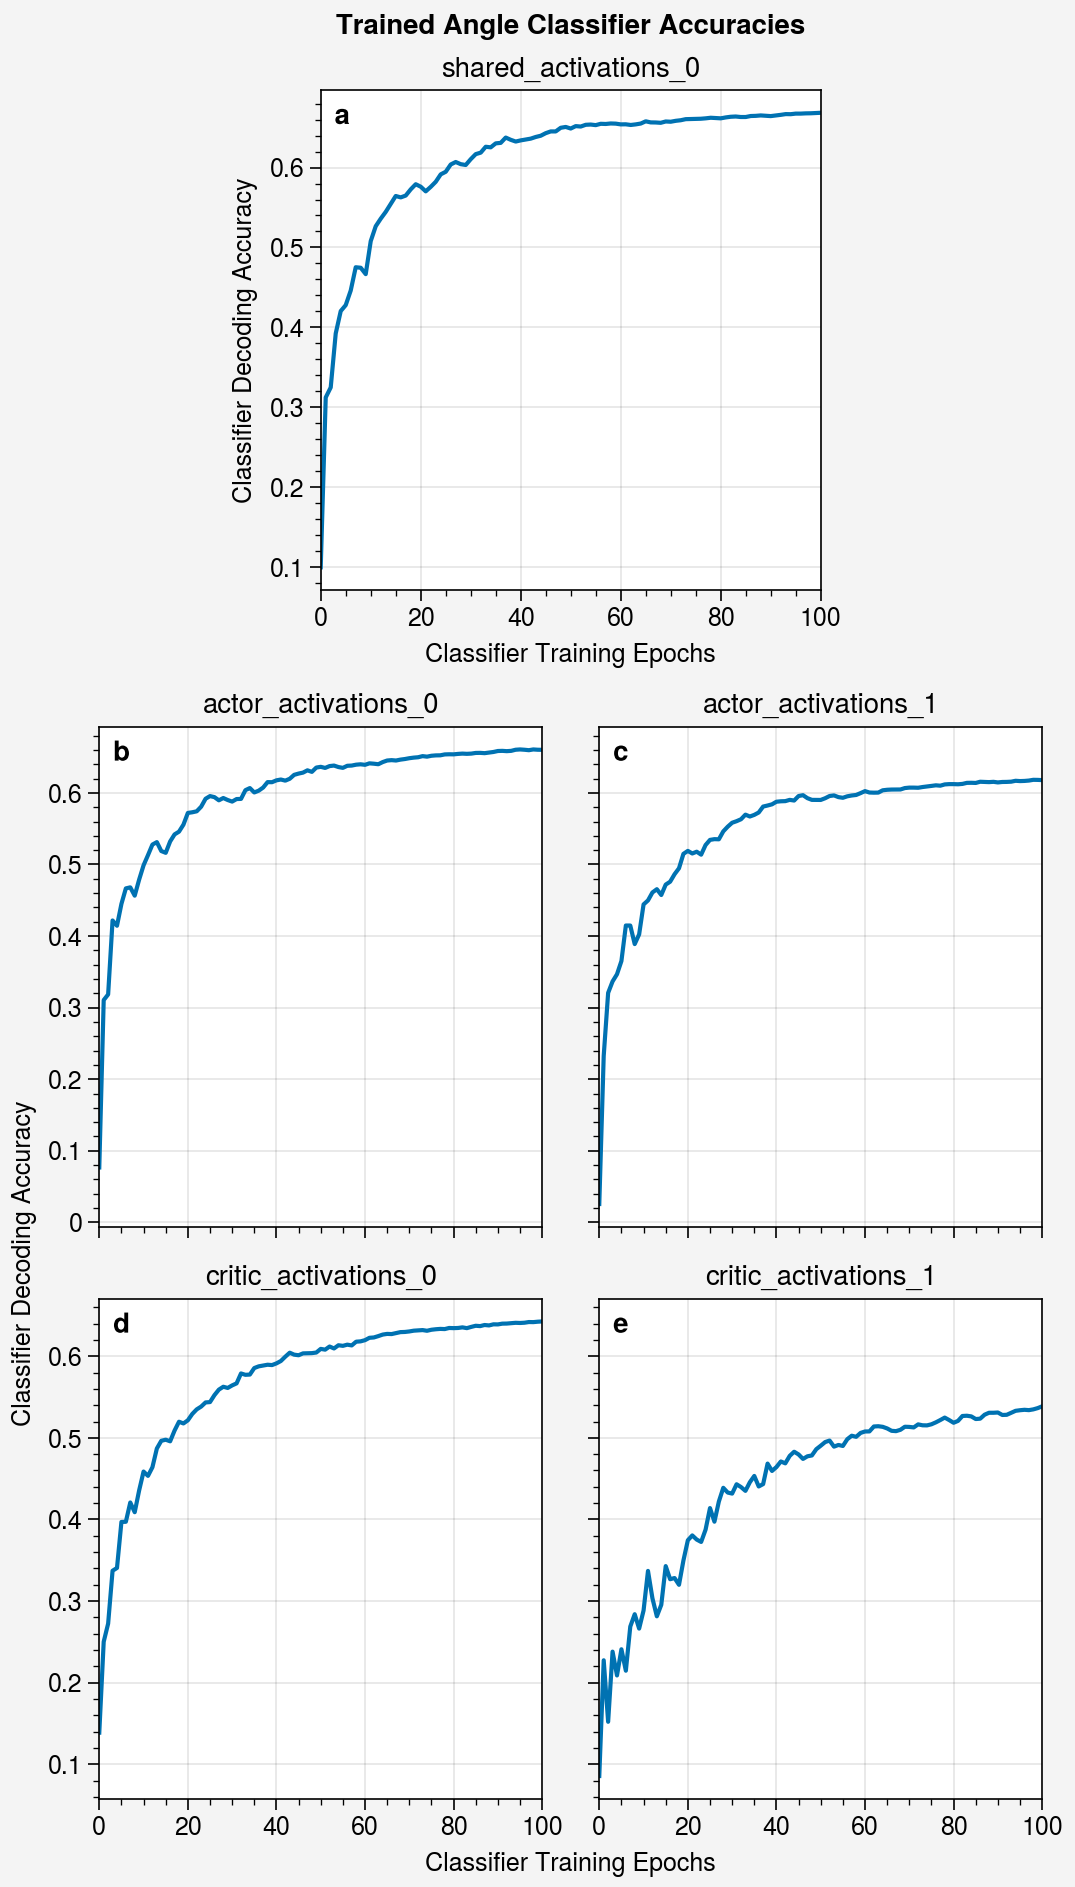

In [14]:
array = [
    [0, 1, 1, 0],
    [2, 2, 3, 3],
    [4, 4, 5, 5]
]
fig, ax = pplt.subplots(array)
ax.format(abc=True, abcloc='ul', 
          suptitle='Trained Angle Classifier Accuracies',
         xlim=(0, 100),
         xlabel='Classifier Training Epochs',
         ylabel='Classifier Decoding Accuracy',
         title=labels)
for i in range(5):
    ax[i].plot(all_accuracies[i])
    
fig.save(save + '3_1_angle_classifier_accuracies.png')

# Comparing different models interpretability levels

In [63]:
print_trained_models(ignore_non_pt=False)

ppo
├── invisible_poster
├── invisible_shared
├── invisible_wallcolors
├── nav_visible_reshaping
├── visible_reshaping
├── visible_wallcolors
├── nav_auxiliary_tasks
│   ├── nav_c2_auxeuclid0_env
│   ├── nav_c2_auxeuclid1_env
│   ├── nav_c2_auxeuclid2_env
│   ├── nav_c2_auxwall1_env
│   ├── nav_c2_auxwall3_env
│   ├── nav_c4_auxeuclid0_env
│   ├── nav_c4_auxeuclid1_env
│   ├── nav_c4_auxeuclid2_env
│   ├── nav_c4_auxwall1_env
│   ├── nav_c4_auxwall3_env
│   ├── EXP nav_c2_auxeuclid0: 5
│   ├── EXP nav_c2_auxeuclid1: 5
│   ├── EXP nav_c2_auxeuclid2: 5
│   ├── EXP nav_c2_auxwall1: 5
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 10
│   ├── EXP nav_c4_auxeuclid1: 10
│   ├── EXP nav_c4_auxeuclid2: 10
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_invisible_shared
│   ├── nav_c4_shared0.dist_env
│   ├── nav_c4_shared0_env
│   ├── nav_c4_shared1.dist_env
│   ├── nav_c4_shared1_env
│   ├── nav_c4_shared2.dist_env
│   ├── nav_c4_shared2_env
│   ├── EXP nav

In [453]:
c4_aux_models = ['nav_auxiliary_tasks/nav_c4_auxwall1', #Report proximal wall
          'nav_auxiliary_tasks/nav_c4_auxwall3', #Report distal wall
          'nav_auxiliary_tasks/nav_c4_auxeuclid2', #Report euclidean distance
          'nav_auxiliary_tasks/nav_c4_auxeuclid1', #Report constant 0
          'nav_auxiliary_tasks/nav_c4_auxeuclid0', #Basic 4 color no task
         ]
pproxim_aux_models = [
          'nav_poster/nav_pproxim_auxwall1', #Report proximal wall
          'nav_poster/nav_pproxim_auxwall2', #Report distal wall
          'nav_poster/nav_pproxim_auxeuclid2', #Report euclidean distance
          'nav_poster/nav_pproxim_auxeuclid1', #Report constant 0
          'nav_poster/nav_pproxim_auxeuclid0', #Basic 4 color no task
         ]
shared_layer_models = [
    'nav_invisible_shared/nav_c4_shared0',
    'nav_invisible_shared/nav_c4_shared1',
    'nav_invisible_shared/nav_c4_shared2'
]

## c4 aux models

In [458]:
all_classifier_results = {}
num_trials = 5
pbar = tqdm(total=len(c4_aux_models)*num_trials)
for model in c4_aux_models:
    all_classifier_results[model] = []
    for i in range(num_trials):
        all_classifier_results[model].append(train_position_classifier(model, model_num=i))
        pbar.update(1)
pbar.close()
pickle.dump(all_classifier_results, open(save + '4_1_c4_aux_model_posdecoder_randact.pickle', 'wb'))


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [15:44<00:00, 37.79s/it]

KeyboardInterrupt



In [460]:
all_classifier_results = pickle.load(open(save + '4_1_c4_aux_model_posdecoder_randact.pickle', 'rb'))

C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)


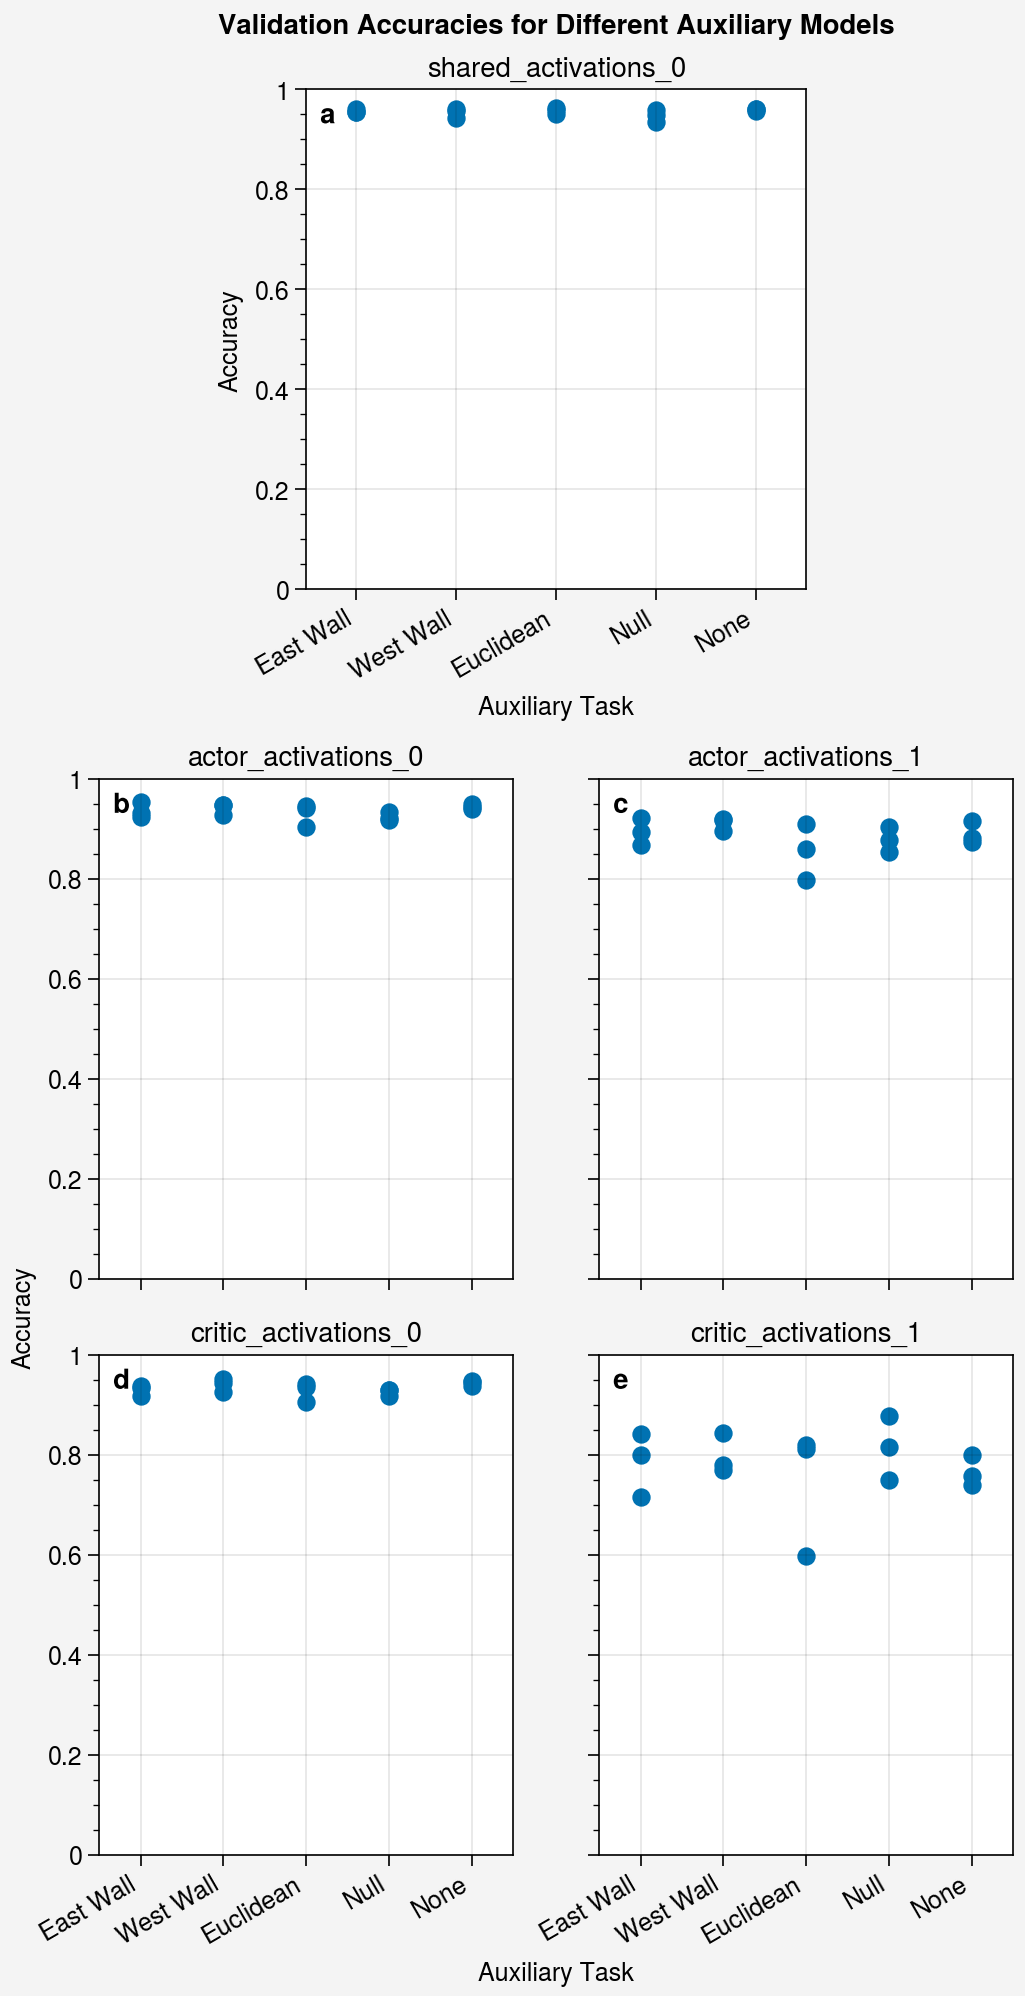

In [361]:
array = [
    [0, 1, 1, 0],
    [2, 2, 3, 3],
    [4, 4, 5, 5]
]

models = list(all_classifier_results)
layers = all_classifier_results[models[0]][0]['labels']
model_labels = ['', 'East Wall', 'West Wall', 'Euclidean', 'Null', 'None']

fig, ax = pplt.subplots(array)
ax.format(abc=True, abcloc='ul',
          suptitle='Validation Accuracies for Different Auxiliary Models',
          ylabel='Accuracy',
          ylim=(0, 1),
          xformatter=model_labels,
          xlim=(-0.5, 4.5),
          # xlocator='index',
          xrotation=30,
          title=layers,
          xlabel='Auxiliary Task')

for i, layer in enumerate(layers):
    xs = []
    ys = []
    
    for j, model in enumerate(models):
        model_results = all_classifier_results[model]
        for k in range(len(model_results)):
            xs.append(j)
            ys.append(all_classifier_results[model][k]['final_valid_acc'][i])
    
    ax[i].scatter(xs, ys)
            
fig.savefig(save + '4_1_c4_aux_model_classifier_accuracies.png')

### Are c4 model positions decodeable between random action and policy actions?

Looks like they have similar susceptibility to false classifier training. This is likely also due to class imbalance? Maybe again a limitation of how classifiers are used for this decoding problem

In [463]:
model = 'nav_auxiliary_tasks/nav_c4_auxeuclid0'
results = perform_ep_collection(model, model_num=0)

classifier_results = train_position_classifier(model, model_num=model_num, random_actions=False)

In [484]:
one_ep = perform_ep_collection(model, model_num=0, random_actions=True)

one_ep_listed_activ, one_ep_pos, one_ep_angle, one_ep_grid_indexes = (
    one_ep['listed_activ'],
    one_ep['pos'],
    one_ep['angle'],
    one_ep['grid_indexes']
)

In [490]:
for i, label in enumerate(classifier_results['labels']):
    activ = one_ep_listed_activ[i]
    classifier = classifier_results['classifiers'][label]
    with torch.no_grad():
        probs = softmax(classifier(activ))
    print(label, accuracy_score(one_ep_grid_indexes, probs.argmax(axis=1)))
    

shared_activations_0 0.10396039603960396
actor_activations_0 0.09900990099009901
actor_activations_1 0.039603960396039604
critic_activations_0 0.09900990099009901
critic_activations_1 0.04455445544554455


## c4 shared layers

In [43]:
all_classifier_results = {}
num_trials = 3
pbar = tqdm(total=len(shared_layer_models)*num_trials)
for model in shared_layer_models:
    all_classifier_results[model] = []
    for i in range(num_trials):
        all_classifier_results[model].append(train_position_classifier(model, model_num=i))
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:25<00:00, 28.65s/it]

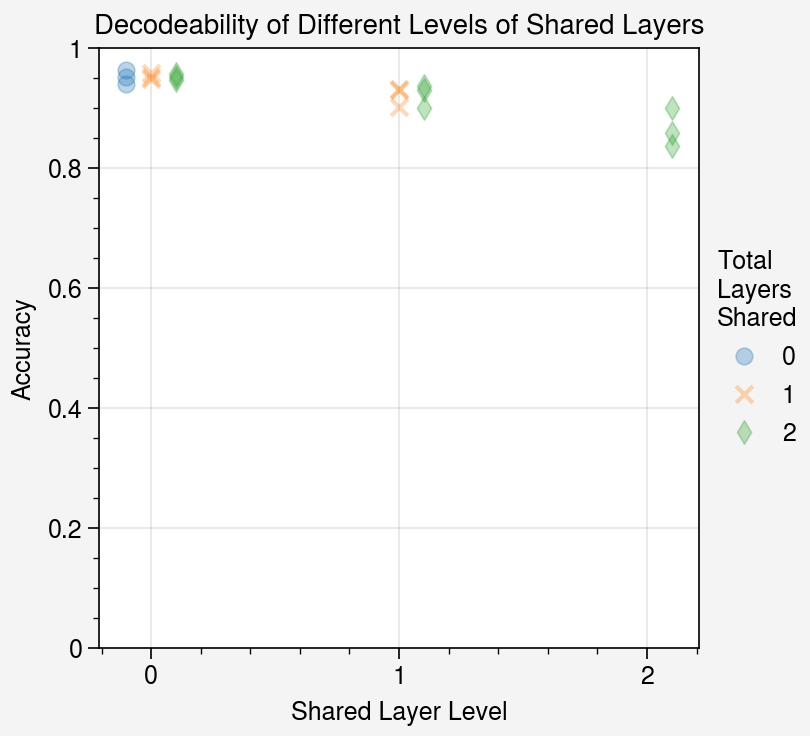

In [57]:
fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=3)

hs = []
cycle = pplt.Cycle('default', m=['o', 'x', 'd'])
for v, model in enumerate(shared_layer_models):
    total_num_shared = model[-1]
    
    xs = []
    ys = []
    for i in range(len(all_classifier_results[model])):
        labels = all_classifier_results[model][i]['labels']
        accuracies = all_classifier_results[model][i]['final_valid_acc']
        for j, label in enumerate(labels):
            if 'shared_activation' in label:
                layer_num = int(label[-1])
                xs.append(layer_num - 0.1 + 0.1*v)
                ys.append(accuracies[j])
    h = ax.scatter(xs, ys, label=total_num_shared, alpha=0.3, cycle=cycle)
    hs.append(h)
ax.format(
    ylim=(0, 1),
    xticks=[0, 1, 2],
    xlabel='Shared Layer Level',
    ylabel='Accuracy',
    title=['Decodeability of Different Levels of Shared Layers']
)

ax.legend(hs, loc='r', frame=False, ncols=1, label='Total\nLayers\nShared')
fig.savefig(save + '4_2_shared_layer_accuracies.png')

## pproxim aux models

In [68]:
model, obs_rms, kwargs = load_model_and_env('nav_poster/nav_pproxim_auxwall1', 0)

In [76]:
all_classifier_results = {}
num_trials = 5
pbar = tqdm(total=len(pproxim_aux_models)*num_trials)
for model in pproxim_aux_models:
    all_classifier_results[model] = []
    for i in range(num_trials):
        all_classifier_results[model].append(train_position_classifier(model, model_num=i))
        pbar.update(1)
pbar.close()

pickle.dump(all_classifier_results, open(save + 'nav_pproxim_position_decoder_results.pickle', 'wb'))

In [166]:
#Load plotting data
all_classifier_results = pickle.load(open(save+'nav_pproxim_position_decoder_results.pickle', 'rb'))

C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
C:\Users\14and\anaconda3\lib\site-packages\proplot\axes\cartesian.py:681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)


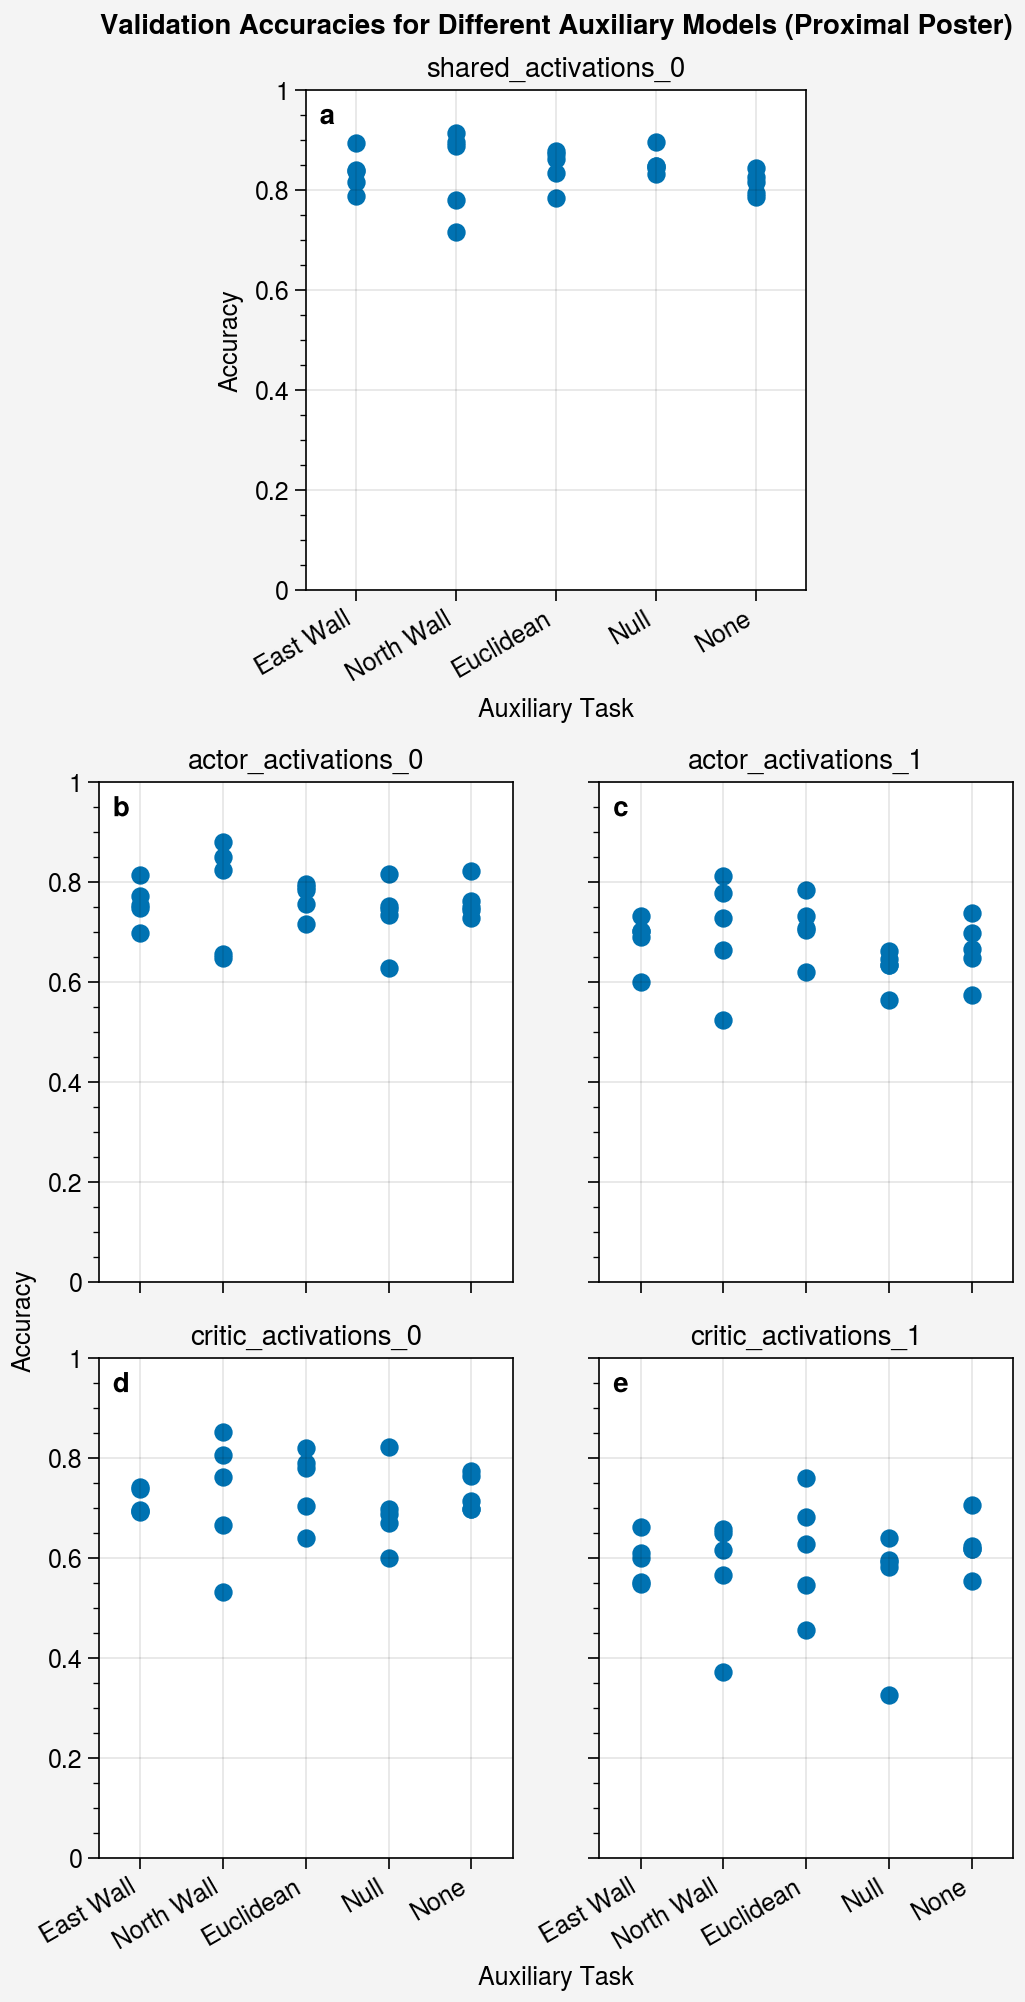

In [231]:
array = [
    [0, 1, 1, 0],
    [2, 2, 3, 3],
    [4, 4, 5, 5]
]

models = list(all_classifier_results)
layers = all_classifier_results[models[0]][0]['labels']
model_labels = ['', 'East Wall', 'North Wall', 'Euclidean', 'Null', 'None']

fig, ax = pplt.subplots(array)
ax.format(abc=True, abcloc='ul',
          suptitle='Validation Accuracies for Different Auxiliary Models (Proximal Poster)',
          ylabel='Accuracy',
          ylim=(0, 1),
          xformatter=model_labels,
          xlim=(-0.5, 4.5),
          # xlocator='index',
          xrotation=30,
          title=layers,
          xlabel='Auxiliary Task')

for i, layer in enumerate(layers):
    xs = []
    ys = []
    
    for j, model in enumerate(models):
        model_results = all_classifier_results[model]
        for k in range(len(model_results)):
            xs.append(j)
            ys.append(all_classifier_results[model][k]['final_valid_acc'][i])
    
    ax[i].scatter(xs, ys)
            
fig.savefig(save + '4_3_pproxim_aux_model_classifier_accuracies.png')

### Exploring more in depth about representations learned

Notes
* On pproxim task it is important for the classifier to be trained on the same kinds of episodes it is evaluated on. E.g., if random actions are used, the episodes used for validation also need to be random actions. Likewise if the policy actions are used
* pproxim agent seems to have interesting representations that are symmetrically encoded, perhaps due to the policy used?

0.011111111111111112


C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


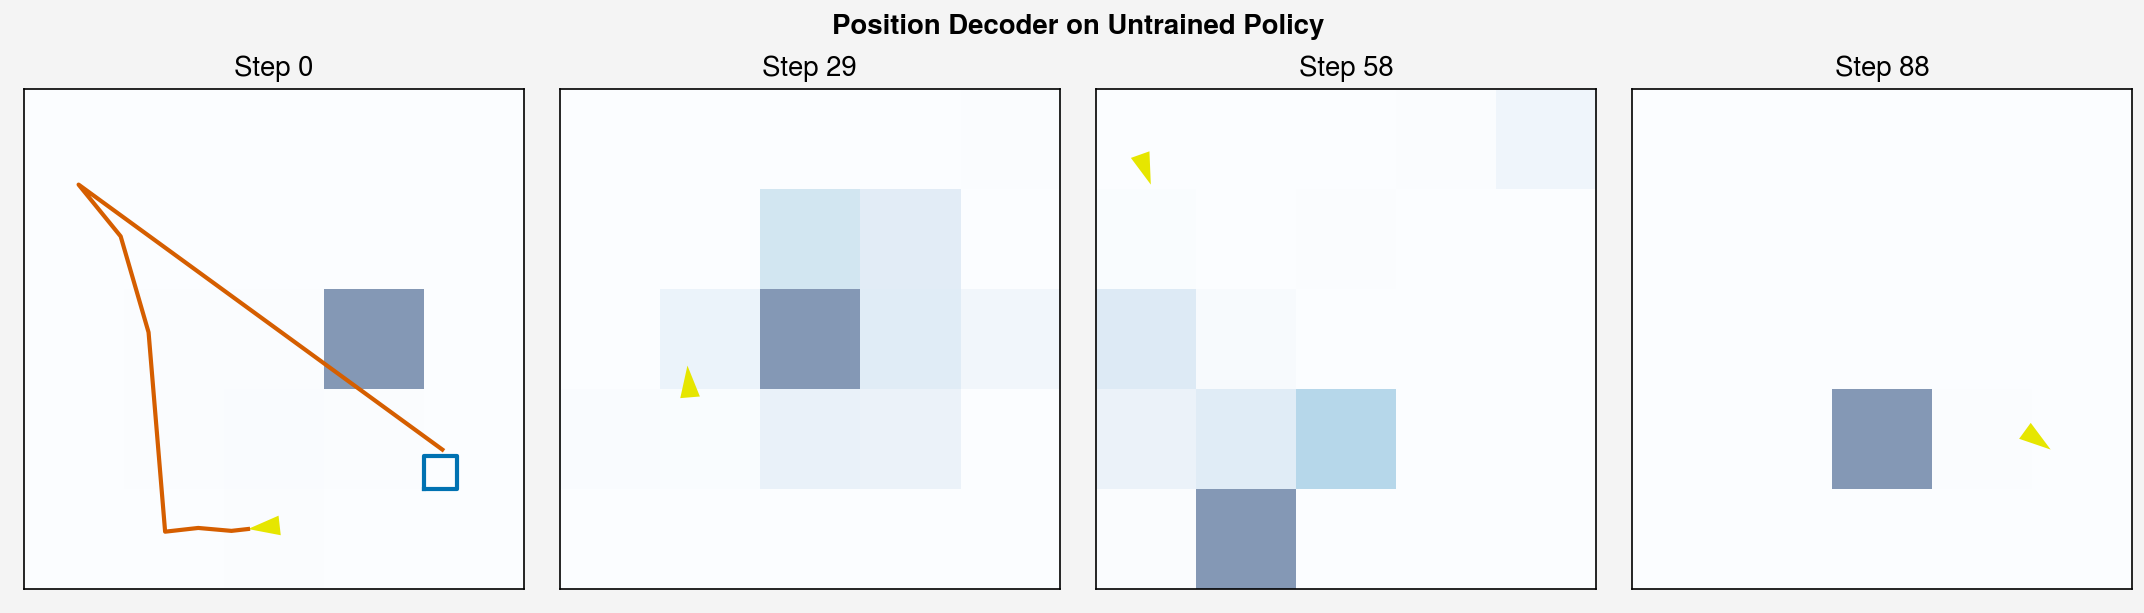

In [323]:
model_name = 'nav_poster/nav_pproxim_auxwall2'
model_num = 0
model, obs_rms, kwargs = load_model_and_env(model_name, model_num)
one_ep = evalu(model, obs_rms, env_kwargs=kwargs, n=1, 
               data_callback=nav_data_callback, with_activations=True)

one_ep_pos = np.vstack(one_ep['data']['pos'])
one_ep_angle = np.vstack(one_ep['data']['angle'])
one_ep_stacked = stack_activations(one_ep['activations'])
one_ep_grid_idxs = [find_grid_index(p) for p in one_ep_pos]


activations_names = ['shared_activations', 'actor_activations', 'actor_activations',
               'critic_activations', 'critic_activations']
activation_idxs = [0, 0, 1, 0, 1]

# activation_name = activations_names[0]
# activation_idx = activation_idxs[0]
# activations = one_ep_stacked[activation_name][activation_idx]
# classifier = all_classifier_results[model_name][model_num]['classifiers'][f'{activation_name}_{activation_idx}']
# probs = softmax(classifier(activations).detach())
# steps = 
activation_name = activations_names[0]
activation_idx = activation_idxs[0]
activations = one_ep_stacked[activation_name][activation_idx]
classifier = results['classifiers'][f'{activation_name}_{activation_idx}']
probs = softmax(classifier(activations).detach())
print(accuracy_score(one_ep_grid_idxs, probs.argmax(axis=1)))

steps = np.linspace(0, len(one_ep_pos)-2, 4).astype(int)
# fig, ax = pplt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
fig, ax = pplt.subplots(nrows=1, ncols=4)
ax.format(
    suptitle='Position Decoder on Untrained Policy',
    title=[f'Step {step}' for step in steps],
         xticks=[],
         yticks=[],
         xlim=[0, 300],
         ylim=[0, 300])

ax[0].plot([240, 240, 260, 260, 240], [60, 80, 80, 60, 60])
ax[0].plot(one_ep_pos.T[0][:-1], one_ep_pos.T[1][:-1])
for i, step in enumerate(steps):
    ax[i].imshow(probs[step].reshape(5,5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    # plt.scatter(one_ep_pos.T[0, :step], one_ep_pos.T[1, :step], alpha=0.2)
    draw_character(one_ep_pos[step], one_ep_angle[step], 20, ax=ax[i])


In [381]:
results = train_position_classifier(model_name, model_num=0, random_actions=False)

73
0.1232876712328767
0.2328767123287671
0.2328767123287671
0.2191780821917808
0.2054794520547945


C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


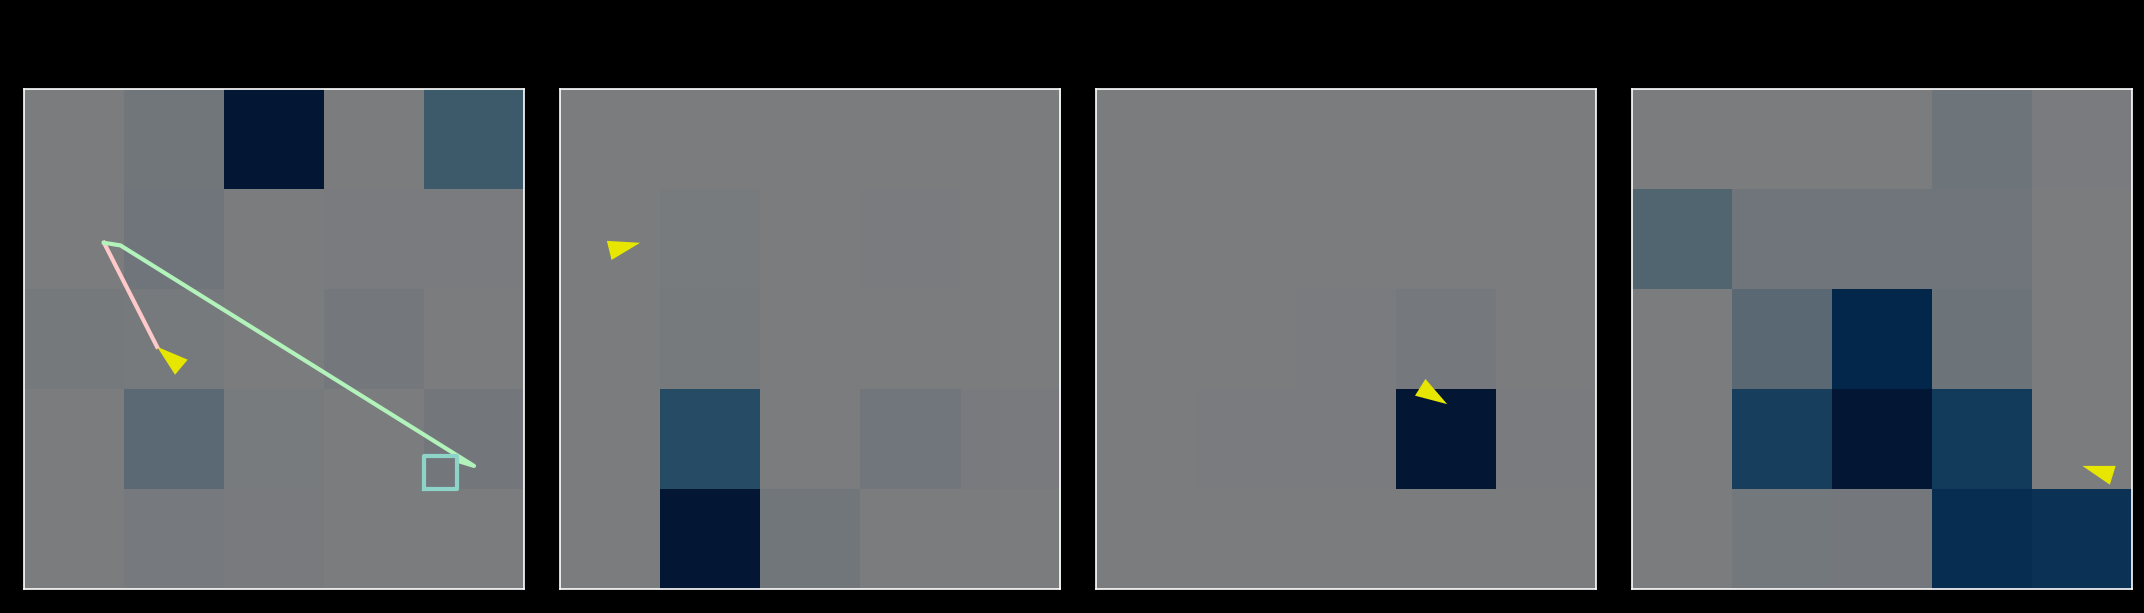

In [451]:
seed = 21
action_randomizer = lambda step: np.random.choice([0, 1, 2])
# one_ep = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
#                                 data_callback=nav_data_callback, num_episodes=1, with_activations=True)
one_ep = forced_action_evaluate(model, obs_rms, env_kwargs=kwargs, seed=seed,
                                data_callback=poster_data_callback, num_episodes=1, with_activations=True)

one_ep_pos = np.vstack(one_ep['data']['pos'])
one_ep_angle = np.vstack(one_ep['data']['angle'])
one_ep_stacked = stack_activations(one_ep['activations'])
one_ep_grid_idxs = [find_grid_index(p) for p in one_ep_pos]

print(len(one_ep_pos))
for i in range(5):
    activation_name = activations_names[i]
    activation_idx = activation_idxs[i]
    activations = one_ep_stacked[activation_name][activation_idx]
    classifier = results['classifiers'][f'{activation_name}_{activation_idx}']
    probs = softmax(classifier(activations).detach())
    # print(probs.argmax(axis=1))
    print(accuracy_score(one_ep_grid_idxs, probs.argmax(axis=1)))
    
steps = np.linspace(0, len(one_ep_pos)-3, 4).astype(int)
# fig, ax = pplt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
fig, ax = pplt.subplots(nrows=1, ncols=4)
ax.format(
    suptitle='Position Decoder on Untrained Policy',
    title=[f'Step {step}' for step in steps],
         xticks=[],
         yticks=[],
         xlim=[0, 300],
         ylim=[0, 300])

see_poster_idxs = np.argwhere(one_ep['data']['poster_seen'])
if len(see_poster_idxs) > 0:
    poster_seen_idx = see_poster_idxs[0][0]
    ax[0].plot(one_ep_pos.T[0][:poster_seen_idx], one_ep_pos.T[1][:poster_seen_idx],
              c='red2')
    ax[0].plot(one_ep_pos.T[0][poster_seen_idx:-1], one_ep_pos.T[1][poster_seen_idx:-1],
              c='green2')    
else:
    ax[0].plot(one_ep_pos.T[0][:-1], one_ep_pos.T[1][:-1], c='red2')
    
ax[0].plot([240, 240, 260, 260, 240], [60, 80, 80, 60, 60])


for i, step in enumerate(steps):
    ax[i].imshow(probs[step].reshape(5,5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    # plt.scatter(one_ep_pos.T[0, :step], one_ep_pos.T[1, :step], alpha=0.2)
    draw_character(one_ep_pos[step], one_ep_angle[step], 20, ax=ax[i])


C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


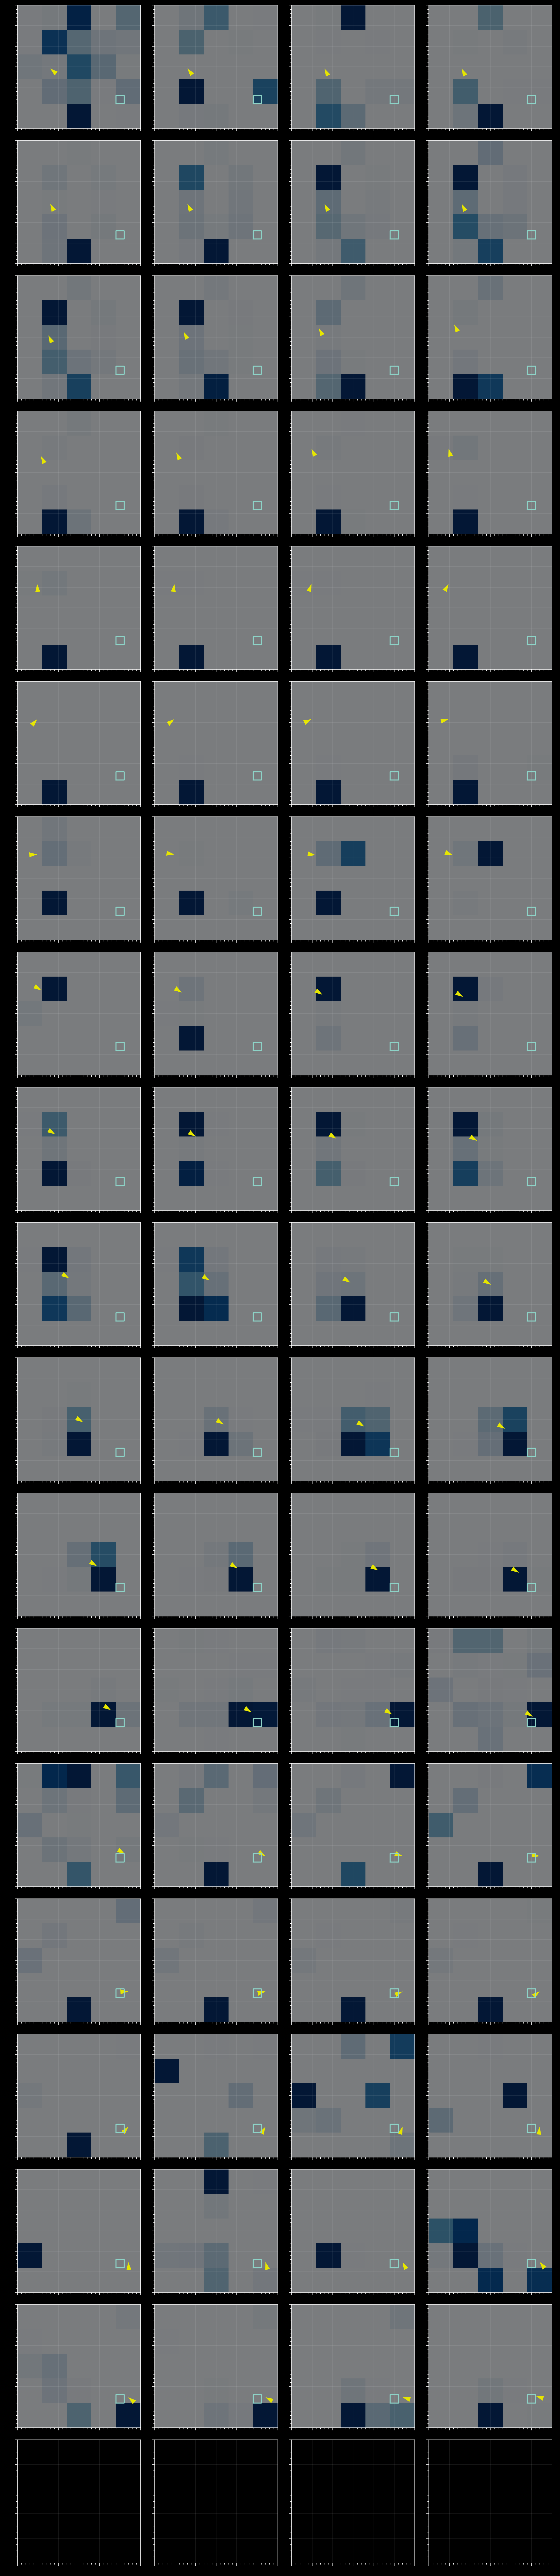

In [452]:
# Show all steps
i = 0
activation_name = activations_names[i]
activation_idx = activation_idxs[i]
activations = one_ep_stacked[activation_name][activation_idx]
classifier = results['classifiers'][f'{activation_name}_{activation_idx}']
probs = softmax(classifier(activations).detach())



nrows = int(np.ceil(len(one_ep_pos) / 4))
fig, ax = pplt.subplots(nrows=nrows, ncols=4)
for i in range(len(one_ep_pos)-1):
    ax[i].imshow(probs[i].reshape(5, 5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    draw_character(one_ep_pos[i], one_ep_angle[i], 20, ax=ax[i])
    ax[i].plot([240, 240, 260, 260, 240], [60, 80, 80, 60, 60])



# Analyzing representation development over training

## Random initiated model

Here we wanted to test how trainable a classifeir with randomly initiated policy would actually be. Turns out not very much.

In [147]:
_, _, kwargs = pickle.load(open('../trained_models/ppo/nav_invisible_shared/nav_c4_shared0_env',  'rb'))
env = gym.make('NavEnv-v0', **kwargs)

model = Policy(env.observation_space.shape,
          env.action_space,
          base='FlexBase',
          base_kwargs={'recurrent': True,
                      'num_shared_layers':  0})
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/',
                     torch.device('cpu'), False, env_kwargs=kwargs)
obs_rms = getattr(utils.get_vec_normalize(envs), 'obs_rms', None)

results = train_position_classifier(model, obs_rms, kwargs)

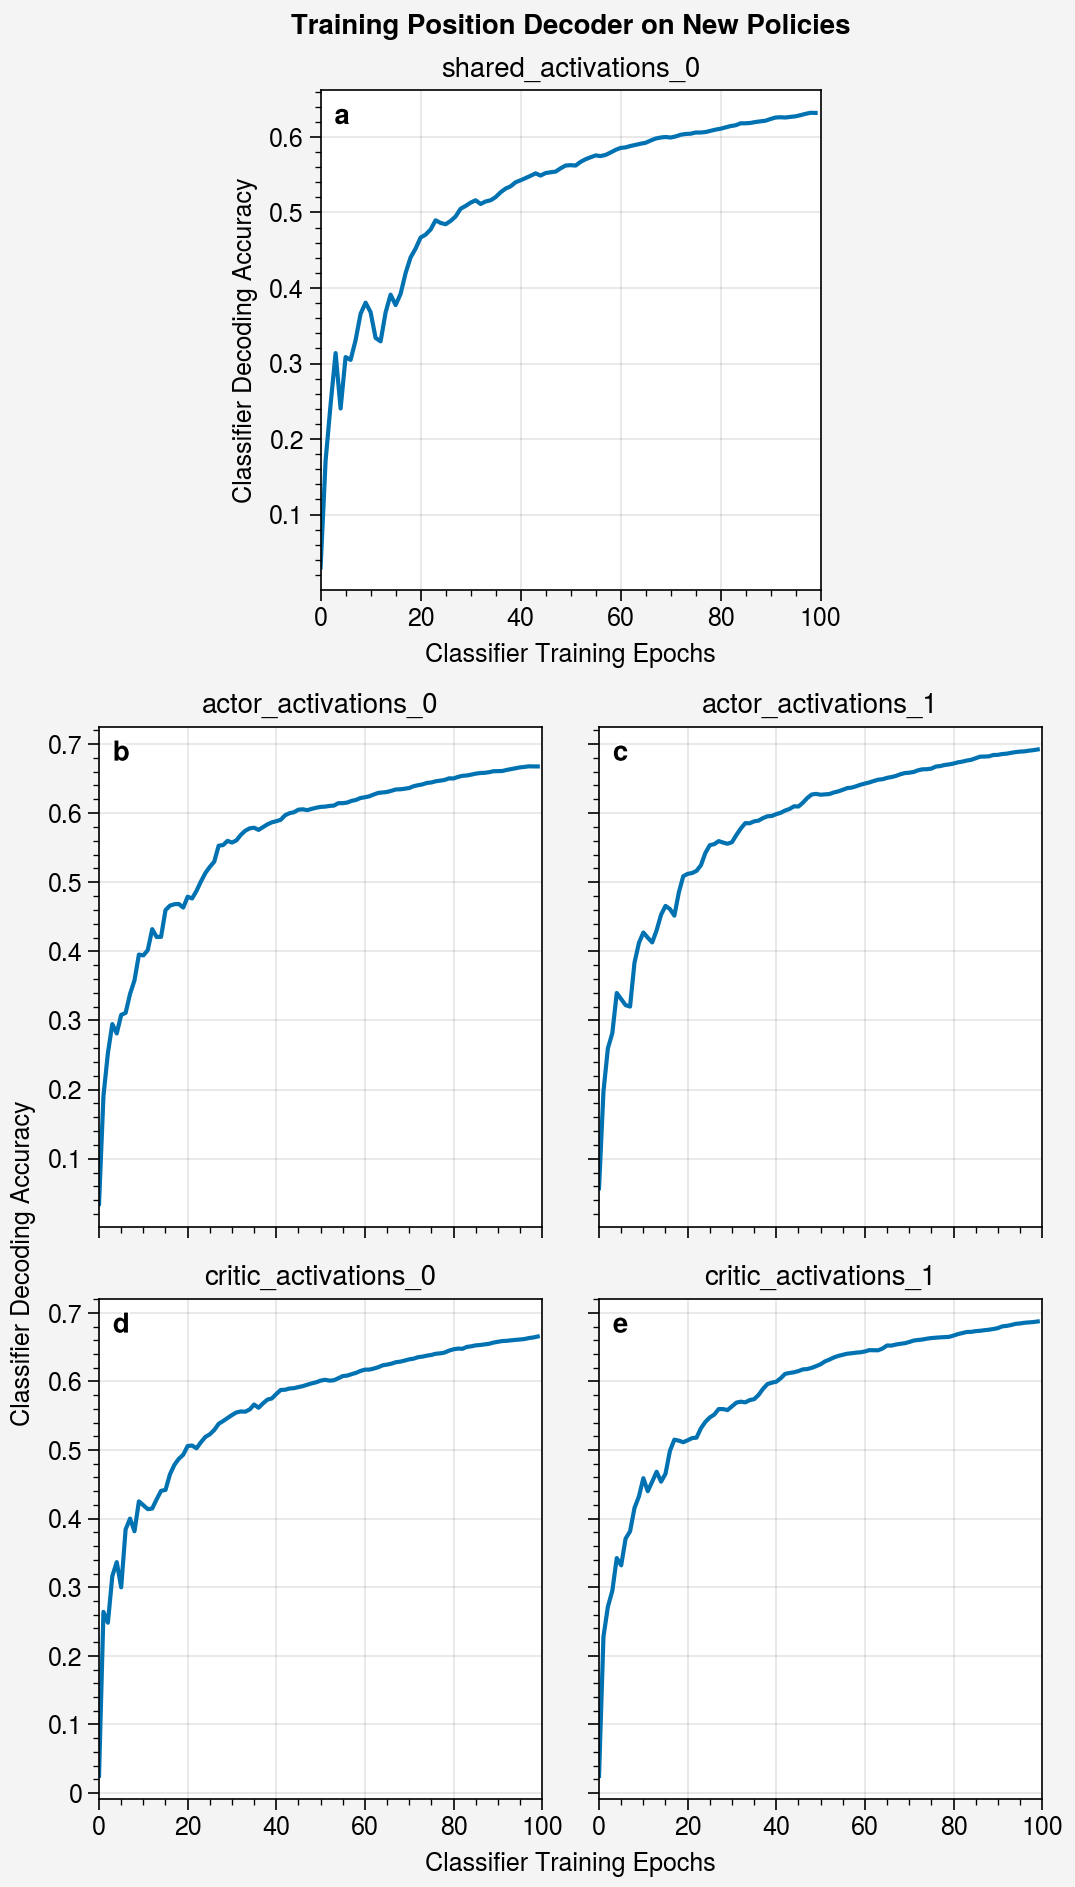

In [175]:
array = [
    [0, 1, 1, 0],
    [2, 2, 3, 3],
    [4, 4, 5, 5]
]
fig, ax = pplt.subplots(array)
ax.format(abc=True, abcloc='ul', 
          suptitle='Training Position Decoder on New Policies',
         xlim=(0, 100),
         xlabel='Classifier Training Epochs',
         ylabel='Classifier Decoding Accuracy',
         title=results['labels'])
for i in range(5):
    ax[i].plot(results['training_acc'][i])
    
fig.save(save + '5_1_position_decoder_untrainedpolicy_classifier_accuracies.png')

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


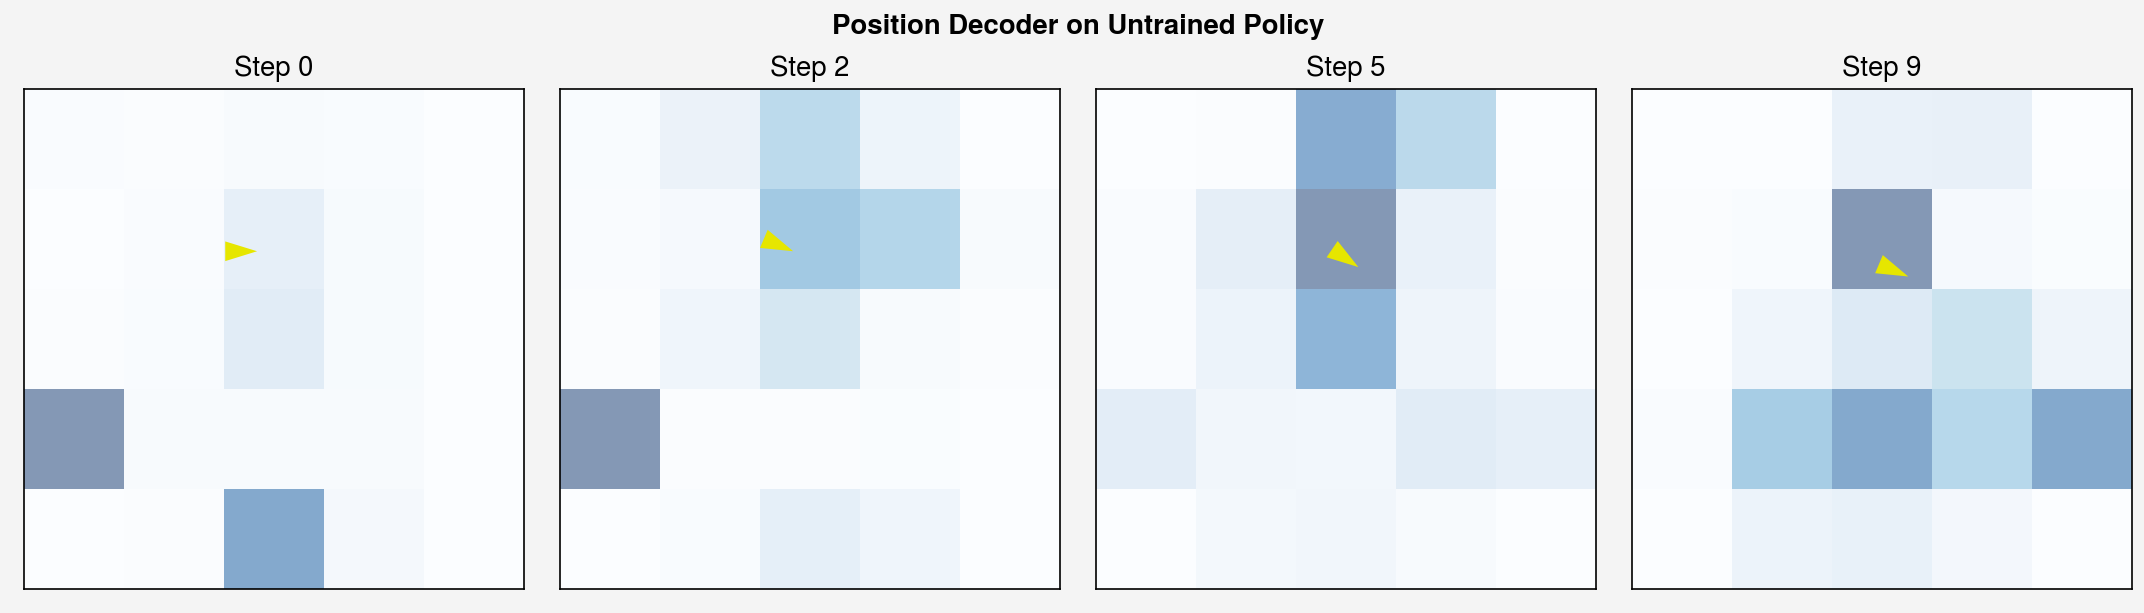

In [174]:
one_ep = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


one_ep_pos = np.vstack(one_ep['data']['pos'])
one_ep_angle = np.vstack(one_ep['data']['angle'])
one_ep_stacked = stack_activations(one_ep['activations'])
classifier = results['classifiers']['shared_activations_0']
with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    y = classifier(one_ep_stacked['shared_activations'][0])
    probs = softmax(y)


steps = [0, 2, 5, 9]
# fig, ax = pplt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
fig, ax = pplt.subplots(nrows=1, ncols=4)
ax.format(
    suptitle='Position Decoder on Untrained Policy',
    title=[f'Step {step}' for step in steps],
         xticks=[],
         yticks=[])

for i, step in enumerate(steps):
    ax[i].imshow(probs[step].reshape(5,5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    # plt.scatter(one_ep_pos.T[0, :step], one_ep_pos.T[1, :step], alpha=0.2)
    draw_character(one_ep_pos[step], one_ep_angle[step], 20, ax=ax[i])

plt.savefig(save + '5_1_untrainedpolicy_live_episode_decoding.png')
    


## Shared layer training checkpoints

In [178]:
folder = '../trained_models/checkpoint'
model_names = ['nav_c4_shared0_t0', 'nav_c4_shared1_t0', 'nav_c4_shared2_t0']
env_folder = '../trained_models/ppo/nav_invisible_shared'
env_names = [f'{env_folder}/{model.split("_t0")[0]}_env' for model in model_names]

checkpoint_results = defaultdict(list)
checkpoint_labels = defaultdict(list)

total_checkpoints = 10 * 3
pbar = tqdm(total=total_checkpoints)
for i in range(len(model_names)):
    model_name = model_names[i]
    env = env_names[i]
    
    checkpoints = list((Path(folder)/model_name).iterdir())
    kwargs = pickle.load(open(env, 'rb'))


    for checkpoint in checkpoints:
        model, obs_rms = torch.load(checkpoint)
        checkpoint_results[model_name].append(train_position_classifier(
            model, obs_rms=obs_rms, kwargs=kwargs
        ))
        checkpoint_labels[model_name].append(int(checkpoints[i].name.split('.pt')[0]))
        pbar.update(1)
pbar.close()

pickle.dump([checkpoint_results, checkpoint_labels], open(save + '5_2_checkpoint_decoder_data.pickle', 'wb'))

In [5]:
#Load data for plot
#Might want to use this later for to further test the classifiers
#  for other measures of total decodeability
checkpoint_results, checkpoint_labels = pickle.load(open(save + '5_2_checkpoint_decoder_data.pickle',  'rb'))

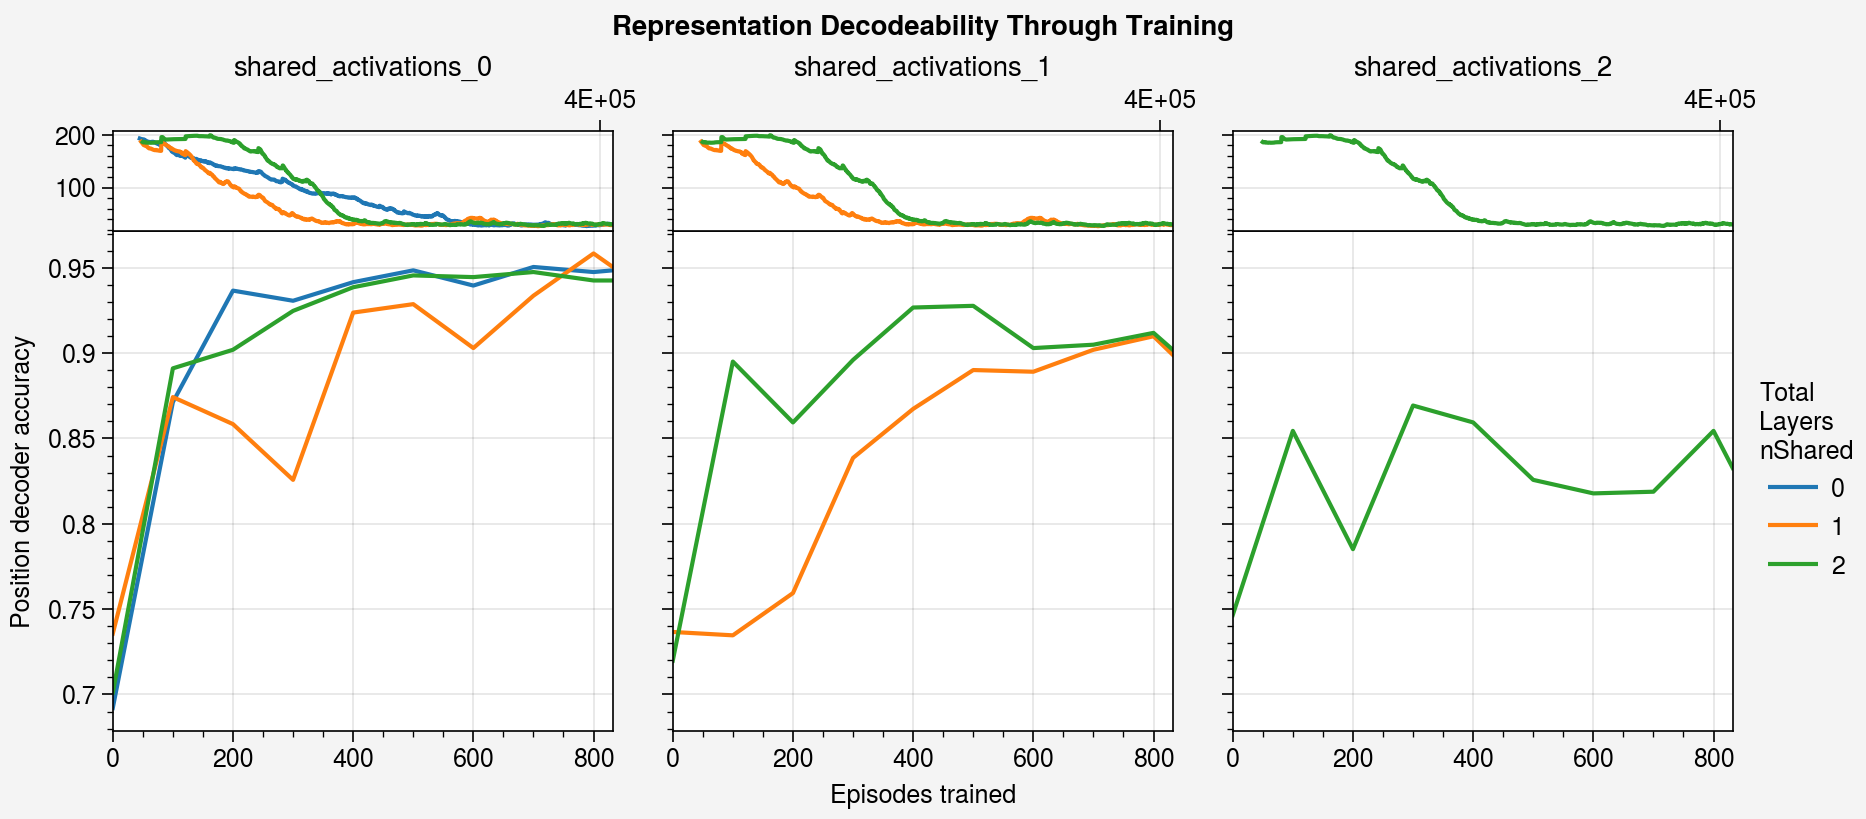

In [220]:
fig, ax = pplt.subplots(nrows=1, ncols=3)

labels = ['shared_activations_0', 'shared_activations_1', 'shared_activations_2']
label_idxs = [0, 1, 2]
ignore_first = 100

ax.format(
    xlabel='Episodes trained',
    ylabel='Position decoder accuracy',
    title=labels,
    suptitle='Representation Decodeability Through Training'
)
taxs = ax.panel('t', space=0, share=False)
taxs.format(title='Model learning curve',
           xticks=[390000],
           xformatter='%.E',
           xlim=[0, 400000])

colors = pplt.Cycle('default').by_key()['color']
hs = []
for i, model_name in enumerate(model_names):
    for j in range(i+1):
        label = labels[j]
        label_idx = label_idxs[j]
        xs = []
        ys = []
        for k in range(len(checkpoint_results[model_name])):
            ys.append(checkpoint_results[model_name][k]['final_valid_acc'][label_idx])
            xs.append(checkpoint_labels[model_name][k])

        xs = [int(checkpoint.name.split('.pt')[0]) for checkpoint in checkpoints]
        h = ax[j].plot(xs, ys, c=colors[i], label=i)
        
        xs2, ys2, min_x, max_x = average_runs(goal_exp_names[i], 'length', ret=True)
        ys2 = ys2.mean(axis=0)
        # xs2 = xs2 / 400000 * 832
        # ys2 = ys2.mean(axis=0) / 200
        taxs[j].plot(xs2[ignore_first:], ys2[ignore_first:], c=colors[i])
    hs.append(h)

fig.legend(hs, loc='r', frame=False, ncols=1, label='Total\nLayers\nnShared')
fig.savefig(save + '5_2_shared_layer_decodeability_training.png')

## Checking decodeability of deepest layer

Decodeability does not seem to improve in the deepest layer as the agent learns to perform the task. So we should confirm first that the deepest layer is not really representing position, then we can start to use this as an exploration of what other deeper features are being learned

In [7]:
checkpoint_results.keys()

dict_keys(['nav_c4_shared0_t0', 'nav_c4_shared1_t0', 'nav_c4_shared2_t0'])

In [12]:
checkpoint_results['nav_c4_shared2_t0'][0]['classifiers']['shared_activations_2']

{'shared_activations_0': Linear(in_features=64, out_features=25, bias=True),
 'shared_activations_1': Linear(in_features=64, out_features=25, bias=True),
 'shared_activations_2': Linear(in_features=64, out_features=25, bias=True)}

In [28]:
seed = 0

model = 'nav_invisible_shared/nav_c4_shared2'
results = train_position_classifier(model, model_num=0, random_actions=False)

In [41]:
seed = 2
activation_name = 'shared_activations'
depth = 2
label = f'{activation_name}_{depth}'
label_idx = 2

one_ep = perform_ep_collection(model, model_num=0, random_actions=False, seed=seed)

one_ep_listed_activ, one_ep_pos, one_ep_angle, one_ep_grid_indexes = (
    one_ep['listed_activ'],
    one_ep['pos'],
    one_ep['angle'],
    one_ep['grid_indexes']
)

activations = one_ep_listed_activ[label_idx]
# classifier = checkpoint_results['nav_c4_shared2_t0'][-1]['classifiers'][label]
classifier = results['classifiers'][label]
probs = softmax(classifier(activations).detach())
print(len(one_ep_pos))
accuracy_score(one_ep_grid_indexes, probs.argmax(axis=1))

29


0.6551724137931034

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


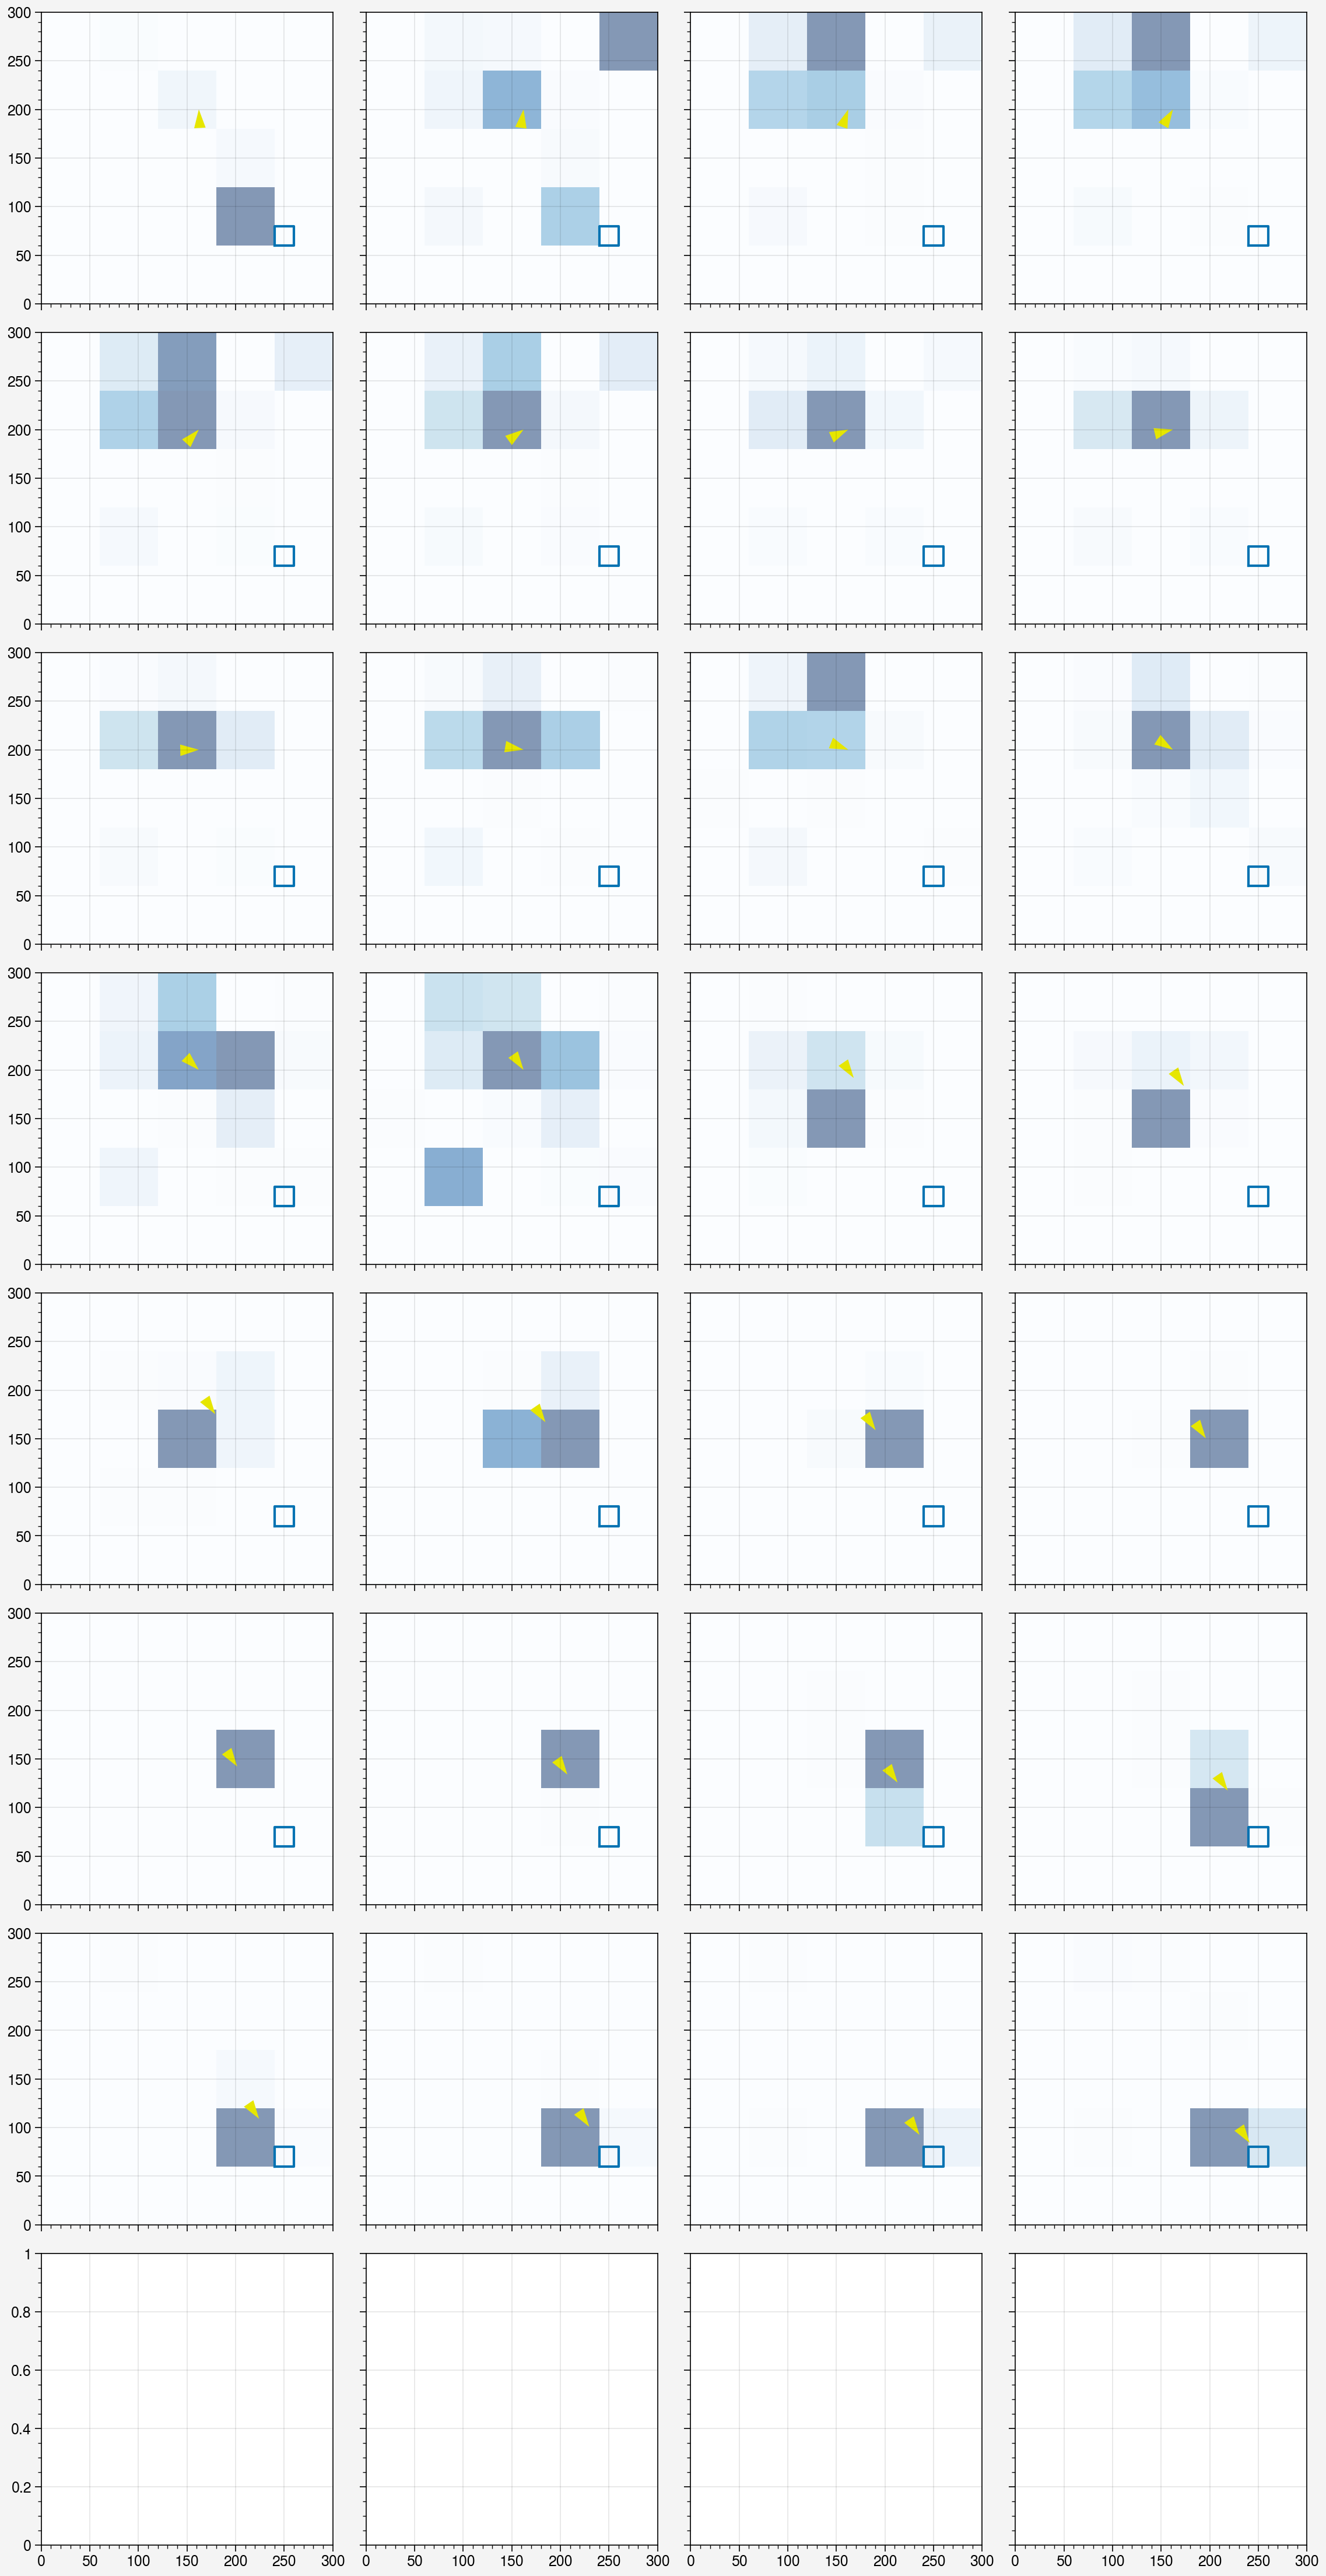

In [42]:
# Show all steps
# max_shown = 20

# nrows = min(int(np.ceil(len(one_ep_pos) / 4)), int(max_shown / 4))
nrows = int(np.ceil(len(one_ep_pos) / 4))
fig, ax = pplt.subplots(nrows=nrows, ncols=4)
for i in range(len(one_ep_pos)-1):
# for i in range(20):
    ax[i].imshow(probs[i].reshape(5, 5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    draw_character(one_ep_pos[i], one_ep_angle[i], 20, ax=ax[i])
    ax[i].plot([240, 240, 260, 260, 240], [60, 80, 80, 60, 60])



C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


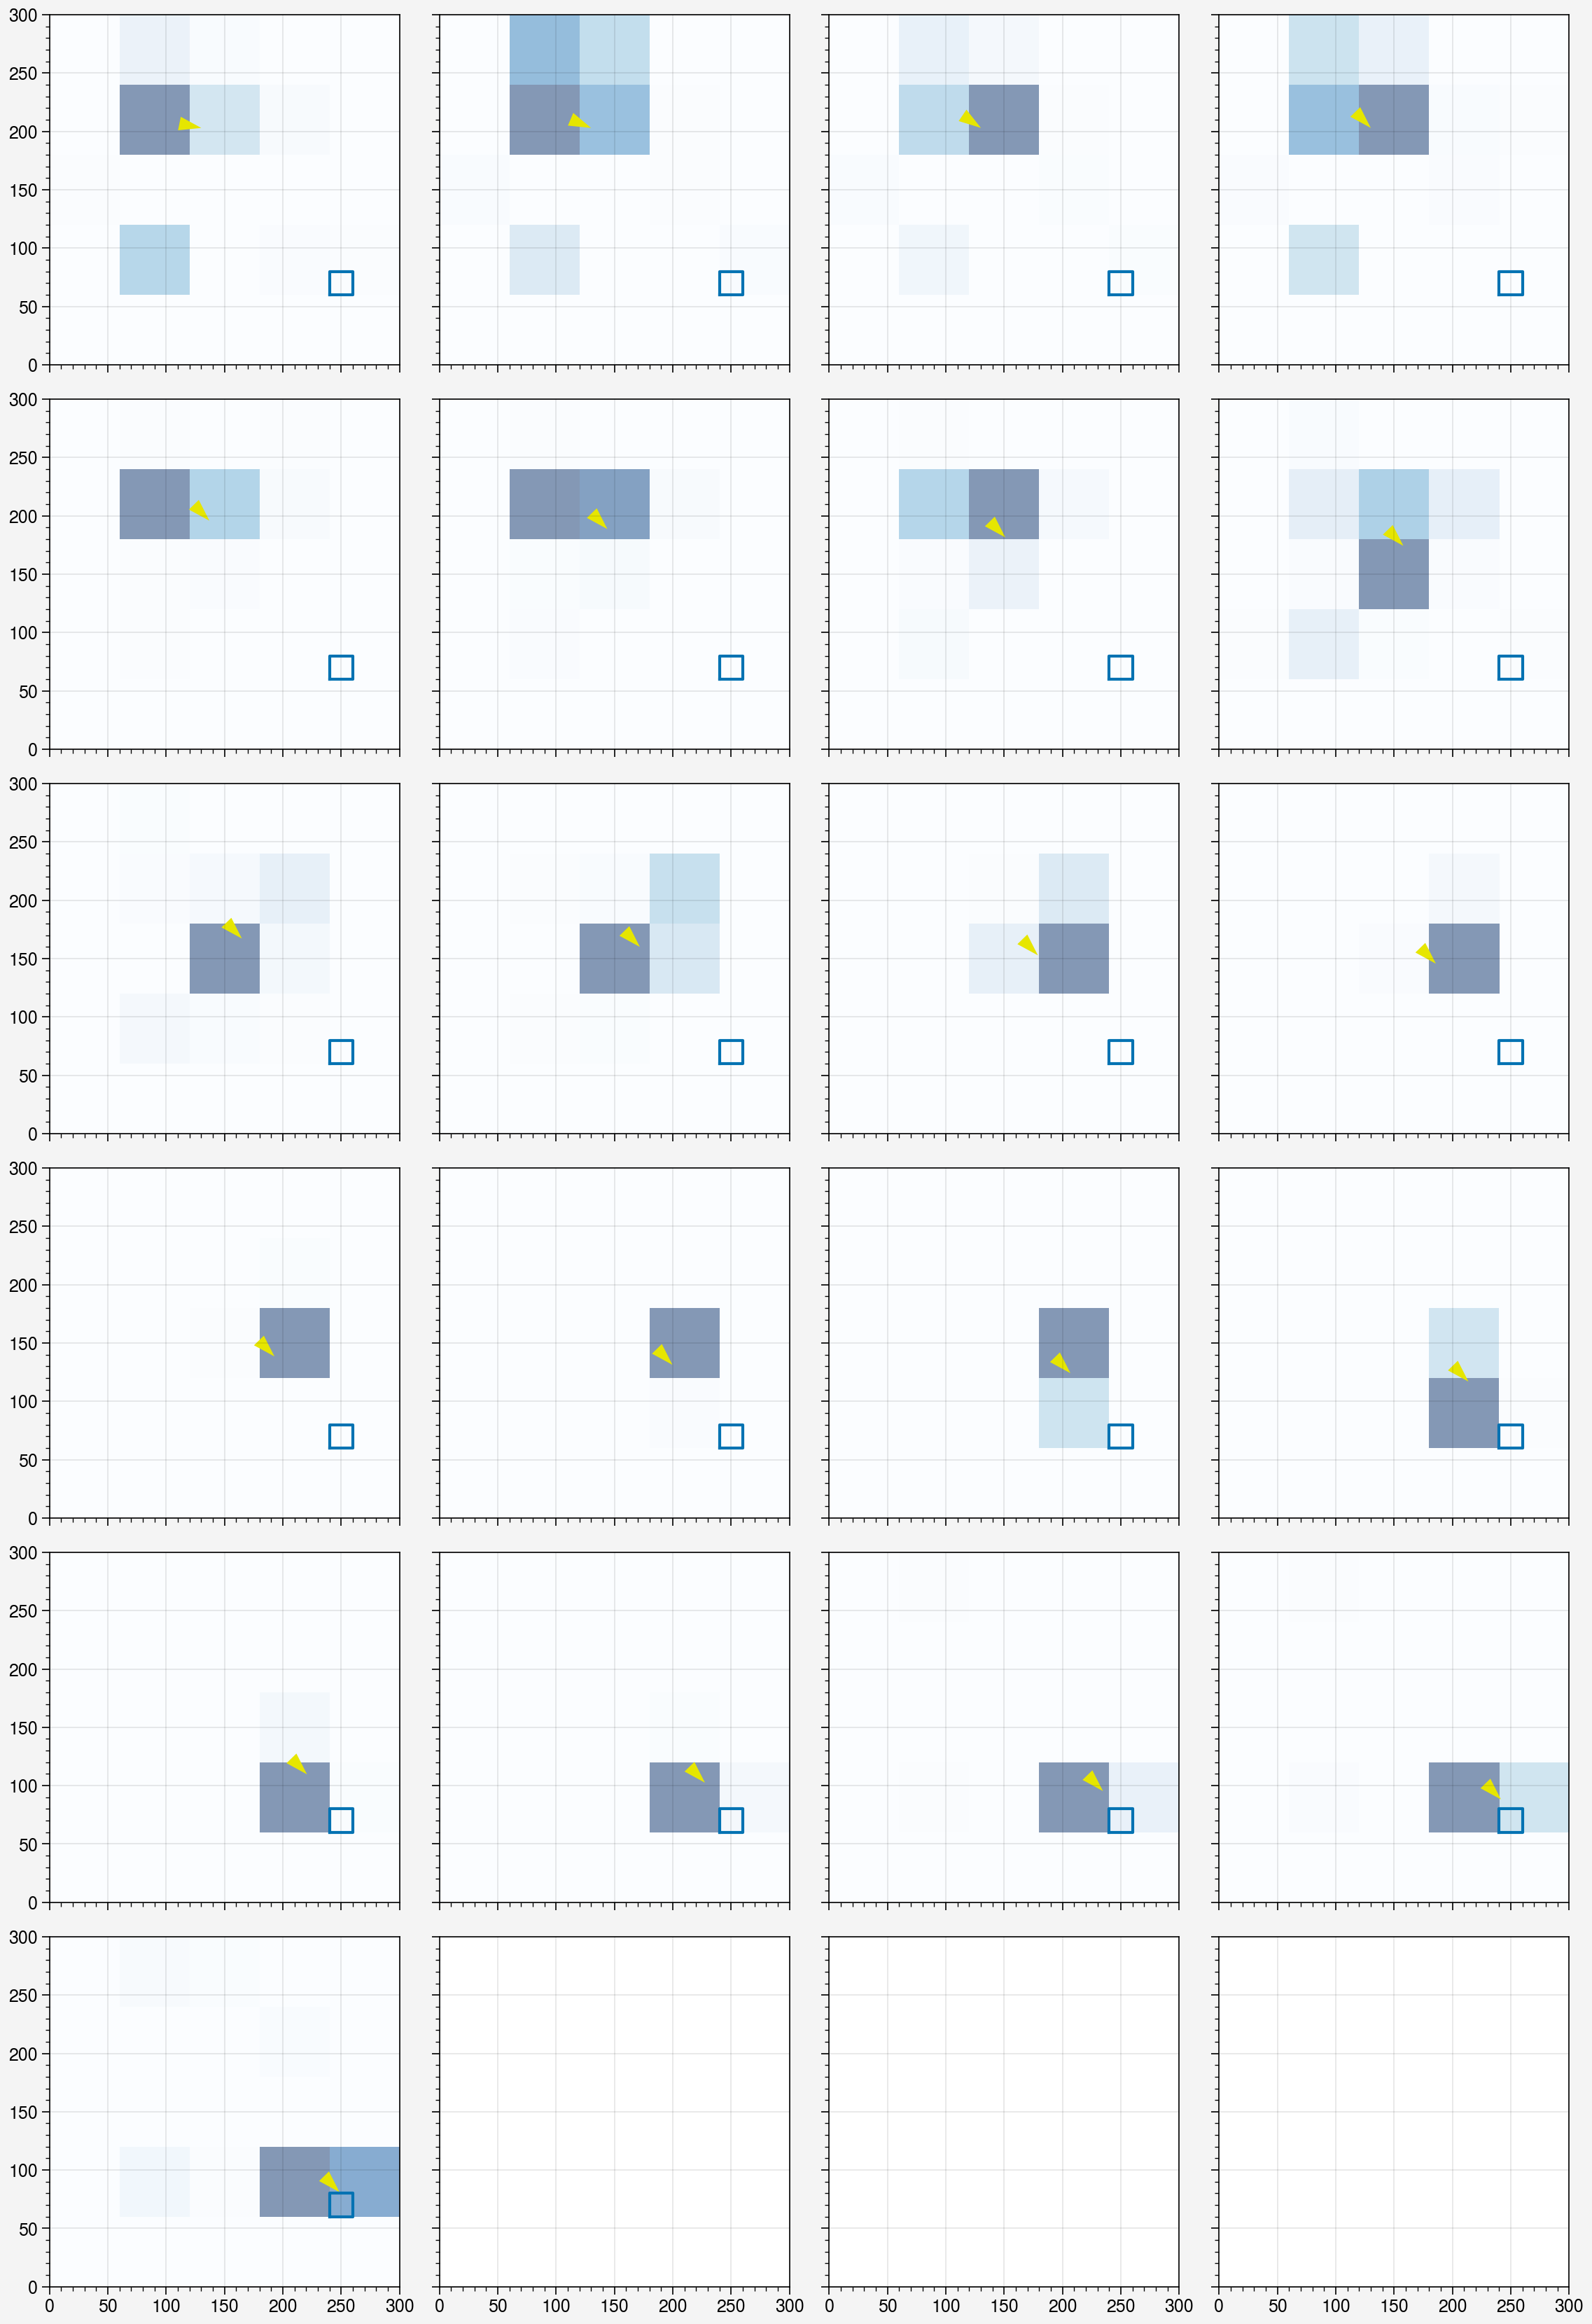

In [30]:
# Show all steps
# max_shown = 20

# nrows = min(int(np.ceil(len(one_ep_pos) / 4)), int(max_shown / 4))
nrows = int(np.ceil(len(one_ep_pos) / 4))
fig, ax = pplt.subplots(nrows=nrows, ncols=4)
for i in range(len(one_ep_pos)-1):
# for i in range(20):
    ax[i].imshow(probs[i].reshape(5, 5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    draw_character(one_ep_pos[i], one_ep_angle[i], 20, ax=ax[i])
    ax[i].plot([240, 240, 260, 260, 240], [60, 80, 80, 60, 60])



## Check whether classifier difference of random actions and policy actions are class imbalance issue

In [3]:
print_trained_models()

ppo
├── nav_auxiliary_tasks
│   ├── EXP nav_c2_auxeuclid0: 5
│   ├── EXP nav_c2_auxeuclid1: 5
│   ├── EXP nav_c2_auxeuclid2: 5
│   ├── EXP nav_c2_auxwall1: 5
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 10
│   ├── EXP nav_c4_auxeuclid1: 10
│   ├── EXP nav_c4_auxeuclid2: 10
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_auxiliary_tasks2
│   ├── EXP nav_c2_auxeuclid0: 4
│   ├── EXP nav_c2_auxeuclid1: 4
│   ├── EXP nav_c2_auxeuclid2: 4
│   ├── EXP nav_c2_auxwall1: 2
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 4
│   ├── EXP nav_c4_auxeuclid1: 5
│   ├── EXP nav_c4_auxeuclid2: 5
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_invisible_shared
│   ├── EXP nav_c4_shared0.dist: 5
│   ├── EXP nav_c4_shared0: 5
│   ├── EXP nav_c4_shared1.dist: 5
│   ├── EXP nav_c4_shared1: 5
│   ├── EXP nav_c4_shared2.dist: 5
│   ├── EXP nav_c4_shared2: 5
├── nav_invisible_shared2
│   ├── EXP nav_c2_shared0: 5
│   ├── EXP nav_c2_share

In [4]:
model = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'
model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'

randact_eps = perform_ep_collection(model, model_num=1, random_actions=True, num_episodes=30)
polact_eps = perform_ep_collection(model, model_num=1, random_actions=False, num_episodes=100)


In [ ]:
def dist(x, y):
    return np.sqrt(np.sum((x - y)**2))

def prune_stuck_pos(pos):
    # polpos = polpos = np.vstack((polact_eps['pos'], [[0, 0],[300,300]]))
    last_pos = np.array([0, 0])
    cum_sim = 0
    start_sim = 0

    all_starts = []
    all_ends = []
    
    min_consec = 50
    
    # Find episodes where agent got stuck by looking for places where it was in the
    # same position for more than min_consec number of timesteps
    for i in range(pos.shape[0]):
        if dist(last_pos, pos[i]) < 2:
            if cum_sim == 0:
                start_sim = i
            cum_sim += 1
        else:
            if cum_sim > min_consec:
                all_starts.append(start_sim)
                all_ends.append(i)

            cum_sim = 0

        last_pos = pos[i]
    
    if len(all_starts) == 0:
        return pos, ([], [])

    
    new_pos = np.array([])
    # Trim these out of positions
    for i in range(len(all_starts)):
        if i == 0:
            new_pos = pos[0:all_starts[0]]
        elif i == len(all_starts) - 1:
            new_pos = np.vstack([new_pos, pos[all_ends[i]:]])
        else:
            new_pos = np.vstack([new_pos, pos[all_ends[i]:all_starts[i+1]]])
    return new_pos, (all_starts, all_ends)
    


def prune_fail_episodes(targets, dones):
    max_ep_len = 202
    done_idxs = np.where(np.vstack(dones))[0]
    diffs = np.diff(done_idxs)
    incomplete_idxs = np.where(diffs == max_ep_len)[0]
    
    pruned_targets = []
    
    for i in range(len(done_idxs)):
        if i == 0:
            done_targets = targets[:done_idxs[i]]
        else:
            done_targets = targets[done_idxs[i-1]:done_idxs[i]]
        
        if i-1 not in incomplete_idxs:
            pruned_targets.append(done_targets)
    
    return pruned_targets

pruned = prune_fail_episodes(polact_eps['pos'], polact_eps['dones'])

In [ ]:
new_pos = np.vstack(pruned)
fig, ax = pplt.subplots()
a = ax.hist2d(new_pos.T[0], new_pos.T[1], bins=30)

In [ ]:
randpos = np.vstack((randact_eps['pos'], [[0, 0],[300,300]])).T
polpos = np.vstack((polact_eps['pos'], [[0, 0],[300,300]])).T

fig, ax = pplt.subplots(nrows=1, ncols=2)
bins = 20
ranbins = ax[0].hist2d(randpos[0], randpos[1], bins=bins)
polbins = ax[1].hist2d(polpos[0], polpos[1], bins=bins,
                      colorbar=True)
pass

In [ ]:
model, obs_rms, kwargs = load_model_and_env(model_name, 0)
envs = quick_vec_env(obs_rms, kwargs)

In [ ]:
env = gym.make('NavEnv-v0', **kwargs)
fig, ax = pplt.subplots(ncols=2, share=True)
pos = []
for i in range(10000):
    env.reset()
    pos.append(env.character.pos)

x = np.vstack(pos).T
a = ax[0].hist2d(x[0], x[1], bins=30)
env.boxes[-1].draw(ax=ax[0])


kwargs2 = kwargs.copy()
kwargs2['character_reset_pos'] = 1
env = gym.make('NavEnv-v0', **kwargs2)

pos = []
for i in range(10000):
    env.reset()
    pos.append(env.character.pos)

x = np.vstack(pos).T
a = ax[1].hist2d(x[0], x[1], bins=30)
env.boxes[-1].draw(ax=ax[1])
ax.format(xlim=[0, 300], ylim=[0, 300])


In [ ]:
kwargs = pickle.load(open('../trained_models/ppo/nav_auxiliary_tasks2/nav_c4_auxeuclid0_env', 'rb'))

## Looking for different ways to search representations

In [ ]:
import umap

In [ ]:
model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'

eps = perform_ep_collection(model_name, model_num=1, 
                                   random_actions=False, num_episodes=100)
reducer = umap.UMAP(random_state=0)
reduced = reducer.fit_transform(shared_activs)

In [ ]:
dones = eps['dones']
shared_activs = torch.vstack(
    prune_fail_episodes(eps['stacked']['shared_activations'][0], dones))
pos = np.vstack(prune_fail_episodes(eps['pos'], dones))
angle = np.vstack(prune_fail_episodes(eps['angle'], dones))
goal_center = np.array([250., 70.])
dists = np.sqrt(((pos - goal_center)**2).sum(axis=1))

#time steps during episodes

steps = []
initial_distances = []
initial_angles = []
i = 1
initial_distance = dist(eps['pos'][0], goal_center)
initial_angle = eps['angle'][0].item()
for j, done in enumerate(dones):
    if done[0] == True:
        i = 1
        initial_distance = dist(eps['pos'][j], goal_center)
        initial_angle = eps['angle'][j].item()
    steps.append(i)
    initial_distances.append(initial_distance)
    initial_angles.append(initial_angle)
    i += 1
steps = np.array(steps)
steps = np.concatenate(prune_fail_episodes(steps, dones))
initial_distances = np.array(initial_distances)
initial_distances = np.concatenate(prune_fail_episodes(initial_distances, dones))
initial_angles = np.array(initial_angles)
initial_angles = np.concatenate(prune_fail_episodes(initial_angles, dones))

In [ ]:
fig, ax = pplt.subplots(nrows=2, ncols=4)
ax.format(
    xlabel='UMAP Dimension 1',
    ylabel='UMAP Dimension 2',
    title=['Angle', 'Dist to Goal', 'Timestep', 'X pos', 'Y pos', 
           'Initial Distance', 'Initial Angle', '']
)
ax[0].scatter(reduced.T[0], reduced.T[1], c=angle.T[0], colorbar='t')
ax[1].scatter(reduced.T[0], reduced.T[1], c=dists, colorbar='t')
ax[2].scatter(reduced.T[0], reduced.T[1], c=steps, colorbar='t')
ax[3].scatter(reduced.T[0], reduced.T[1], c=pos.T[0], colorbar='t')
ax[4].scatter(reduced.T[0], reduced.T[1], c=pos.T[1], colorbar='t')
ax[5].scatter(reduced.T[0], reduced.T[1], c=initial_distances, colorbar='t')
ax[6].scatter(reduced.T[0], reduced.T[1], c=initial_angles, colorbar='t')

### Heatmap activation nodes

In [ ]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(64):
    ax[i].scatter(pos.T[0], pos.T[1], c=shared_activs[:, i], alpha=0.5)
# plt.scatter(pos.T[0], pos.T[1], c=shared_activs[:, 0], alpha=0.5)

**Here we use starting positions along the outside perimeter of the pool as the agent tends to move towards the goal directly**

In [ ]:
#Starting points for the next cell

fine_pos = np.linspace(5, 295, 30)
starting_pos = []
#top and bottom row starts
for i in range(len(fine_pos)):
    starting_pos.append([fine_pos[i], 295])
    starting_pos.append([fine_pos[i], 5])
    
#left and right column starts
for i in range(1, len(fine_pos)-1):
    starting_pos.append([5, fine_pos[i]])
    starting_pos.append([295, fine_pos[i]])

starting_pos = np.array(starting_pos)

fig, ax = pplt.subplots()
ax.scatter(starting_pos.T[0], starting_pos.T[1])
ax.format(title='Manual starting positions')

In [ ]:
#Generate activations for episodes starting from edges of the maze

model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'
model, obs_rms, kwargs = load_model_and_env(model_name, 0)

all_results = []
for i in tqdm(range(len(starting_pos))):
    point = starting_pos[i]
    angle = None
    kwargs['fixed_reset'] = [point, angle]
    results = evalu(model, obs_rms, n=1, env_kwargs=kwargs, with_activations=True,
                    data_callback=nav_data_callback)
    all_results.append(results)


stacked_activations = [stack_activations(all_results[i]['activations']) for i in range(len(all_results))]
keys = stacked_activations[0].keys()
all_stacked_activations = defaultdict(list)
for key in keys:
    for i in range(len(stacked_activations)):
        all_stacked_activations[key].append(stacked_activations[i][key])
    all_stacked_activations[key] = torch.cat(all_stacked_activations[key], dim=1)

This shows the path that the agent takes when given these starting conditions

In [ ]:
fixpos = np.vstack([np.vstack(all_results[i]['data']['pos']) for i in range(len(all_results))])

fig, ax = pplt.subplots()
ax.scatter(fixpos.T[0], fixpos.T[1], alpha=0.3)

In [ ]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(64):
    ax[i].scatter(fixpos.T[0], fixpos.T[1], c=all_stacked_activations['shared_activations'][0, :, i], alpha=0.5)
# plt.scatter(pos.T[0], pos.T[1], c=shared_activs[:, 0], alpha=0.5)

**Now we take grid steps and random actions**

In [ ]:
grid_points = []
for x in fine_pos:
    for y in fine_pos:
        grid_points.append(np.array([x, y]))
grid_points = np.vstack(grid_points)

model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'
model, obs_rms, kwargs = load_model_and_env(model_name, 0)

kwargs['max_steps'] = 20
action_randomizer = lambda step: np.random.choice([0, 1, 2])

all_results = []
for i in tqdm(range(len(grid_points))):
    point = grid_points[i]
    angle = None
    kwargs['fixed_reset'] = [point, angle]
    results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                    data_callback=nav_data_callback, num_episodes=1, with_activations=True
                                    )
    all_results.append(results)
    
ignore_first = 5 #ignore first 5 steps of each episode

In [ ]:
stacked_activations = [stack_activations(all_results[i]['activations']) for i in range(len(all_results))]
keys = stacked_activations[0].keys()
all_stacked_activations = defaultdict(list)
for key in keys:
    for i in range(len(stacked_activations)):
        if len(all_results[i]['data']['pos']) > ignore_first+1:
            all_stacked_activations[key].append(stacked_activations[i][key][:, ignore_first:-1, :])
    all_stacked_activations[key] = torch.cat(all_stacked_activations[key], dim=1)
    
randpos = []
for i in range(len(all_results)):
    pos_data = all_results[i]['data']['pos']
    if len(pos_data) > ignore_first+1:
        randpos.append(pos_data[ignore_first:-1])

randpos = np.vstack(randpos)

fig, ax = pplt.subplots()
ax.scatter(randpos.T[0], randpos.T[1], alpha=0.1)

In [ ]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(64):
    ax[i].scatter(randpos.T[0], randpos.T[1], c=all_stacked_activations['shared_activations'][0, :, i], alpha=0.1)
# plt.scatter(pos.T[0], pos.T[1], c=shared_activs[:, 0], alpha=0.5)

**One more time with more randomzied actions since they were made consistent by the seed**

In [ ]:
grid_points = []
for x in fine_pos:
    for y in fine_pos:
        grid_points.append(np.array([x, y]))
grid_points = np.vstack(grid_points)

model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'
model, obs_rms, kwargs = load_model_and_env(model_name, 0)

kwargs['max_steps'] = 20
action_randomizer = lambda step: np.random.choice([0, 1, 2])

all_results = []
for i in tqdm(range(len(grid_points))):
    point = grid_points[i]
    angle = None
    kwargs['fixed_reset'] = [point, angle]
    results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                    data_callback=nav_data_callback, num_episodes=1, with_activations=True,
                                    seed=i)
    all_results.append(results)
    
ignore_first = 5 #ignore first 5 steps of each episode

stacked_activations = [stack_activations(all_results[i]['activations']) for i in range(len(all_results))]
keys = stacked_activations[0].keys()
all_stacked_activations = defaultdict(list)
for key in keys:
    for i in range(len(stacked_activations)):
        if len(all_results[i]['data']['pos']) > ignore_first+1:
            all_stacked_activations[key].append(stacked_activations[i][key][:, ignore_first:-1, :])
    all_stacked_activations[key] = torch.cat(all_stacked_activations[key], dim=1)
    
randpos = []
for i in range(len(all_results)):
    pos_data = all_results[i]['data']['pos']
    if len(pos_data) > ignore_first+1:
        randpos.append(pos_data[ignore_first:-1])

randpos = np.vstack(randpos)

fig, ax = pplt.subplots()
ax.scatter(randpos.T[0], randpos.T[1], alpha=0.1)

In [ ]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(64):
    ax[i].scatter(randpos.T[0], randpos.T[1], c=all_stacked_activations['shared_activations'][0, :, i], alpha=0.1)
# plt.scatter(pos.T[0], pos.T[1], c=shared_activs[:, 0], alpha=0.5)

**Fixed seed different? Maybe one headed away from goal**

In [ ]:
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True,
                                seed=2)
pos = np.vstack(results['data']['pos']).T
fig, ax = pplt.subplots()
ax.scatter(pos[0], pos[1], c=np.arange(pos.shape[1]))

In [ ]:
grid_points = []
for x in fine_pos:
    for y in fine_pos:
        grid_points.append(np.array([x, y]))
grid_points = np.vstack(grid_points)

model_name = 'nav_auxiliary_tasks2/nav_c4_auxeuclid1'
model, obs_rms, kwargs = load_model_and_env(model_name, 0)

kwargs['max_steps'] = 20
action_randomizer = lambda step: np.random.choice([0, 1, 2])

all_results = []
for i in tqdm(range(len(grid_points))):
    point = grid_points[i]
    angle = None
    kwargs['fixed_reset'] = [point, angle]
    results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                    data_callback=nav_data_callback, num_episodes=1, with_activations=True,
                                    seed=2)
    all_results.append(results)
    
ignore_first = 5 #ignore first 5 steps of each episode

stacked_activations = [stack_activations(all_results[i]['activations']) for i in range(len(all_results))]
keys = stacked_activations[0].keys()
all_stacked_activations = defaultdict(list)
for key in keys:
    for i in range(len(stacked_activations)):
        if len(all_results[i]['data']['pos']) > ignore_first+1:
            all_stacked_activations[key].append(stacked_activations[i][key][:, ignore_first:-1, :])
    all_stacked_activations[key] = torch.cat(all_stacked_activations[key], dim=1)
    
randpos = []
for i in range(len(all_results)):
    pos_data = all_results[i]['data']['pos']
    if len(pos_data) > ignore_first+1:
        randpos.append(pos_data[ignore_first:-1])

randpos = np.vstack(randpos)

fig, ax = pplt.subplots()
ax.scatter(randpos.T[0], randpos.T[1], alpha=0.1)

In [ ]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(64):
    ax[i].scatter(randpos.T[0], randpos.T[1], c=all_stacked_activations['shared_activations'][0, :, i], alpha=0.1)
# plt.scatter(pos.T[0], pos.T[1], c=shared_activs[:, 0], alpha=0.5)